In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings


## Load Data

### Migration influx

In [2]:
with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")

for c in countries:
    df_all.loc[df_all["country"] == c, "value"].fillna(
        df_all.loc[df_all["country"] == c].mean(), inplace=True
    )  # fill missing data with mean

series = {c: df_all[df_all.country == c].value for c in countries}
series["NL"]


date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

### Google trends

In [3]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]]["mean"].columns.to_list()
dataframes["NL"].head()


mean                                                         \
keyword_id          2         10         11         12         14         15   
date                                                                           
2007-01-01  12.142857   7.142857  20.714286   0.000000  19.428571  66.142857   
2007-02-01   0.000000   0.000000  56.857143   0.000000   0.000000  54.428571   
2007-03-01   0.000000  72.000000   0.000000  44.571429  13.142857  42.142857   
2007-04-01  16.571429  39.857143  22.285714   0.000000  12.285714  18.142857   
2007-05-01  11.428571   0.000000   5.857143   0.000000  18.285714   0.000000   

                                                        ...       sem  \
keyword_id         16         17         18         19  ...       114   
date                                                    ...             
2007-01-01   0.000000   0.000000  34.142857  28.142857  ...  0.746876   
2007-02-01  23.857143  36.000000   0.000000  32.000000  ...  0.918443   
2007-03-01   0.000000  36.428571   0.000000  37.285714  ...  1.445142   
2007-04-01   0.000000   0.000000   0.000000  35.285714  ...  1.148794   
2007-05-01   0.000000   0.000000  20.857143  37.857143  ...  1.078548   

                                                                        \
keyword_id       115       117       118       119       121       122   
date                                                                     
2007-01-01  4.838901  4.921838  1.269742  1.130890  1.242666  2.918391   
2007-02-01  2.542161  1.784285  2.307928  0.961858  1.360272  3.508008   
2007-03-01  5.588496  4.276180  1.737932  1.151751  0.911006  3.952094   
2007-04-01  4.495652  4.729413  1.442786  0.755929  1.127878  4.779491   
2007-05-01  6.014721  5.019011  1.397276  1.016865  0.404061  7.008256   

                                          
keyword_id       123       124       125  
date                                      
2007-01-01  1.056242  0.925820  0.480929  
2007-02-01  1.317078  1.192379  0.611678  
2007-03-01  0.972408  0.577350  0.606092  
2007-04-01  0.459221  0.737711  0.714286  
2007-05-01  0.993174  0.968904  0.649437  

[5 rows x 96 columns]

### Macroeconomics

In [4]:
def read_gdp(filename, country_names, skiprows=10, nrows=38):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows)

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df[df["GEO/TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("GEO/TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "gdp", "GEO/TIME": "country"})
    )
    df.index = pd.to_datetime(df.index)
    return df


def read_unempl(filename, country_names, skiprows=10, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Sheet 1")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "unempl", "TIME": "country"})
        .replace({":": np.nan})
    )

    df.index = pd.to_datetime(df.index)
    return df


def read_share_young_pop(filename, country_names, skiprows=9, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Share Young Pop")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "share_young_pop", "TIME": "country"})
    )

    df.index = pd.to_datetime(df.index)
    return df


with open("../macroeconomics/country_names.json") as f:
    country_names = json.load(f)

df_gdp = read_gdp("../macroeconomics/GDP_pc_quart.xls", country_names)
df_unempl = read_unempl("../macroeconomics/Unemployment_Rate_Quart.xlsx", country_names)
df_share_young_pop = read_share_young_pop("../macroeconomics/Share_Young_Population.xlsx", country_names)
df_share_young_pop
# df_unempl


country  share_young_pop
2004-01-01      BE         0.183531
2004-01-01      BG         0.209908
2004-01-01      CZ         0.225508
2004-01-01      DK         0.176100
2004-01-01      EE         0.217808
...            ...              ...
2019-01-01      LU         0.191188
2019-01-01      HU         0.171723
2019-01-01      NL         0.188275
2019-01-01      AT         0.177618
2019-01-01      PL         0.171216

[304 rows x 2 columns]

### Resample, transform and merge

In [5]:
dfs_1m = {
    k: ((df - df.shift(12)).rolling(3).mean()/df.mean()).fillna(0) for k, df in dataframes.items()
}
sers_1m = {
    k: ((df - df.shift(12)) / df.shift(12)).fillna(0) for k, df in series.items()
}

tmp_dfs = []

for c in countries:
    tmp_dep = (
        sers_1m[c]
        .to_frame()
        .assign(country=c)
        .assign(month=sers_1m[c].index.month.astype(str))
    )
    tmp_ind = dfs_1m[c]["mean"].shift(1)
    tmp_ind_1 = dfs_1m[c]["mean"].shift(2).rename(columns=lambda x: x + "_1")
    tmp_ind_2 = dfs_1m[c]["mean"].shift(2).rename(columns=lambda x: x + "_2")
    tmp_ind_3 = dfs_1m[c]["mean"].shift(4).rename(columns=lambda x: x + "_3")
    tmp_ind_6 = dfs_1m[c]["mean"].shift(7).rename(columns=lambda x: x + "_6")
    tmp_ind_9 = dfs_1m[c]["mean"].shift(10).rename(columns=lambda x: x + "_9")
    tmp_ind_12 = dfs_1m[c]["mean"].shift(13).rename(columns=lambda x: x + "_12")
    tmp_df = pd.concat(
        [tmp_dep, tmp_ind, tmp_ind_1, tmp_ind_2, tmp_ind_3, tmp_ind_6, tmp_ind_9, tmp_ind_12], axis=1
    )["2010-12-31":"2019-12-31"]
    tmp_dfs.append(tmp_df)

df_panel_1y = pd.concat(tmp_dfs).sort_index()

for df in [df_share_young_pop, df_gdp, df_unempl]:
    df_tmp = (
        df.groupby([pd.Grouper(freq="1M"), "country"]).mean().shift(12).pct_change()
    )
    df_panel_1y = df_panel_1y.join(
        df_tmp, on=[df_panel_1y.index, df_panel_1y["country"]], how="left"
    )

df_panel_1y


value country month         2        10        11        12  \
date                                                                         
2011-01-01  0.029834      FR     1 -0.593569  1.251277 -0.260629  0.031828   
2011-01-01  0.321429      IE     1  0.000000  0.000000  1.052316  0.000000   
2011-01-01  0.732977      GR     1  0.000000  0.000000  0.000000  0.000000   
2011-01-01  0.226792      HU     1  0.000000  0.000000  1.273363  0.000000   
2011-01-01  0.483844      BG     1  0.000000  0.000000 -0.610010  1.645272   
...              ...     ...   ...       ...       ...       ...       ...   
2019-12-01  0.257732      IE    12  0.000000  0.000000  0.362495  0.000000   
2019-12-01 -0.008174      NL    12  0.060696  0.387968  0.340865 -0.473446   
2019-12-01  0.000000      SK    12  0.000000  0.000000  0.000000  0.000000   
2019-12-01 -0.094595      FI    12  0.000000  0.000000  0.000000  0.000000   
2019-12-01  0.381503      LU    12  0.000000  0.000000  2.974776  0.000000   

                  14        15        16  ...    118_12    119_12    121_12  \
date                                      ...                                 
2011-01-01 -0.091733 -0.326579 -0.369384  ...  0.011159  0.515199 -0.018335   
2011-01-01  0.000000  0.000000  0.000000  ...  0.578553 -0.008067  0.015567   
2011-01-01  0.000000  0.000000  0.000000  ...  0.399310  0.058481  0.074495   
2011-01-01  0.000000  0.000000  0.000000  ...  0.437476  0.006373 -0.101207   
2011-01-01  2.131980  0.000000  0.000000  ...  0.245127  0.224894  0.096645   
...              ...       ...       ...  ...       ...       ...       ...   
2019-12-01  0.000000  0.000000  0.000000  ... -0.136704  0.010083  0.027675   
2019-12-01  0.481731 -0.688525  0.358189  ... -0.085236  0.012364  0.068691   
2019-12-01  0.000000  0.000000  0.000000  ... -0.123043  0.038628 -0.026673   
2019-12-01  0.000000  0.000000  0.000000  ...  0.011656 -0.002535  0.106423   
2019-12-01  0.000000  0.000000  0.000000  ...  0.670347  0.074195  0.035177   

              122_12    123_12    124_12    125_12  share_young_pop  gdp  \
date                                                                       
2011-01-01 -0.073258 -0.114566  0.010051  0.071812              NaN  NaN   
2011-01-01 -0.422182 -0.178528  0.031708 -0.005088              NaN  NaN   
2011-01-01 -0.329627 -0.016501 -0.008687  0.141628              NaN  NaN   
2011-01-01 -0.030687  0.239259  0.068326  0.207224              NaN  NaN   
2011-01-01  0.042385  0.037686 -0.108856  0.314806              NaN  NaN   
...              ...       ...       ...       ...              ...  ...   
2019-12-01  0.147076 -0.025504  0.200159  0.081412              NaN  NaN   
2019-12-01  0.024275 -0.062957  0.097213  0.163837              NaN  NaN   
2019-12-01  0.318732  0.025036  0.088129  0.464164              NaN  NaN   
2019-12-01  0.203463  0.174957  0.148644  0.148578              NaN  NaN   
2019-12-01  0.009441 -0.060025  0.374607  0.115214              NaN  NaN   

            unempl  
date                
2011-01-01     NaN  
2011-01-01     NaN  
2011-01-01     NaN  
2011-01-01     NaN  
2011-01-01     NaN  
...            ...  
2019-12-01     NaN  
2019-12-01     NaN  
2019-12-01     NaN  
2019-12-01     NaN  
2019-12-01     NaN  

[2916 rows x 342 columns]

## Evaluation functions and common variables

In [12]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import feature_selection
from sklearn import compose
from sklearn import impute
from sklearn import neural_network

t_min = "2011-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

scoring = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error", "r2"]

# selected_countries = ["FR", "GB", "IT", "ES", "RO"]
selected_countries = countries


df_panel_1y = df_panel_1y[df_panel_1y.country.isin(selected_countries)]

dummies_country = pd.get_dummies(df_panel_1y["country"], drop_first=False)
dummy_cols = dummies_country.columns.tolist()

dummies_month = pd.get_dummies(df_panel_1y["month"], prefix="month", drop_first=False)
dummy_cols_month = dummies_month.columns.tolist()

df_tmp_combined = df_panel_1y["country"] + "_" + df_panel_1y["month"]
dummies_combined = pd.get_dummies(df_tmp_combined, drop_first=False)
dummy_cols_combined = dummies_combined.columns.tolist()

df_panel_1y = pd.concat(
    [df_panel_1y, dummies_country, dummies_month, dummies_combined], axis=1
)

x = df_panel_1y.drop(columns="value")[t_min:t_max]
y = df_panel_1y["value"][t_min:t_max]

x_train = x[t_min:t_split_lower]
y_train = y[t_min:t_split_lower]
x_test = x[t_split_upper:t_max]
y_test = y[t_split_upper:t_max]


def score_cv(reg, X, y):
    scores = model_selection.cross_validate(reg, X=X, y=y, scoring=scoring)
    return pd.DataFrame(scores)


def score_test(reg, X, y):
    scores = {s: metrics.get_scorer(s)(reg, X, y) for s in scoring}
    return pd.Series(scores)


def plot_panel(df, countries, n_rows=7, n_cols=4, figsize=(25, 25), autoscale=True):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(countries, axs.flatten()):
        df_to_plot = df[df["country"] == c].drop(columns="country")
        if autoscale is not None:
            y_max = max([df_to_plot[col].max() for col in df_to_plot.columns])
            y_min = min([df_to_plot[col].min() for col in df_to_plot.columns])
        df_to_plot.plot(ax=ax, ylim=(y_min * 1.2, y_max * 1.2) if autoscale else None)
        ax.set_title(c)
    fig.tight_layout()
    return fig, axs


def plot_prediction(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    return plot_panel(df_pred, countries, **kwargs)


def plot_residuals(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    df_pred["residuals"] = df_pred["pred"] - df_pred["value"]
    return plot_panel(df_pred[["residuals", "country"]], countries, **kwargs)



## Models

### Country dummies

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.006141    0.009609                            -2.174805e+12   
1  0.015777    0.005189                            -6.163562e+11   
2  0.010447    0.004724                            -1.801843e+12   
3  0.009928    0.011070                            -4.162610e+12   
4  0.010212    0.004363                            -1.116502e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.442910 -0.680716  
1                         -0.254079  0.107130  
2                         -0.348743  0.028365  
3                         -0.223577 -0.727538  
4                         -0.244092 -2.664338

Mean CV score:


fit_time                                   1.050091e-02
score_time                                 6.991100e-03
test_neg_mean_absolute_percentage_error   -1.974423e+12
test_neg_root_mean_squared_error          -3.026804e-01
test_r2                                   -7.874194e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -3.737661e+13
neg_root_mean_squared_error          -2.009253e-01
r2                                   -1.414099e+00
dtype: float64

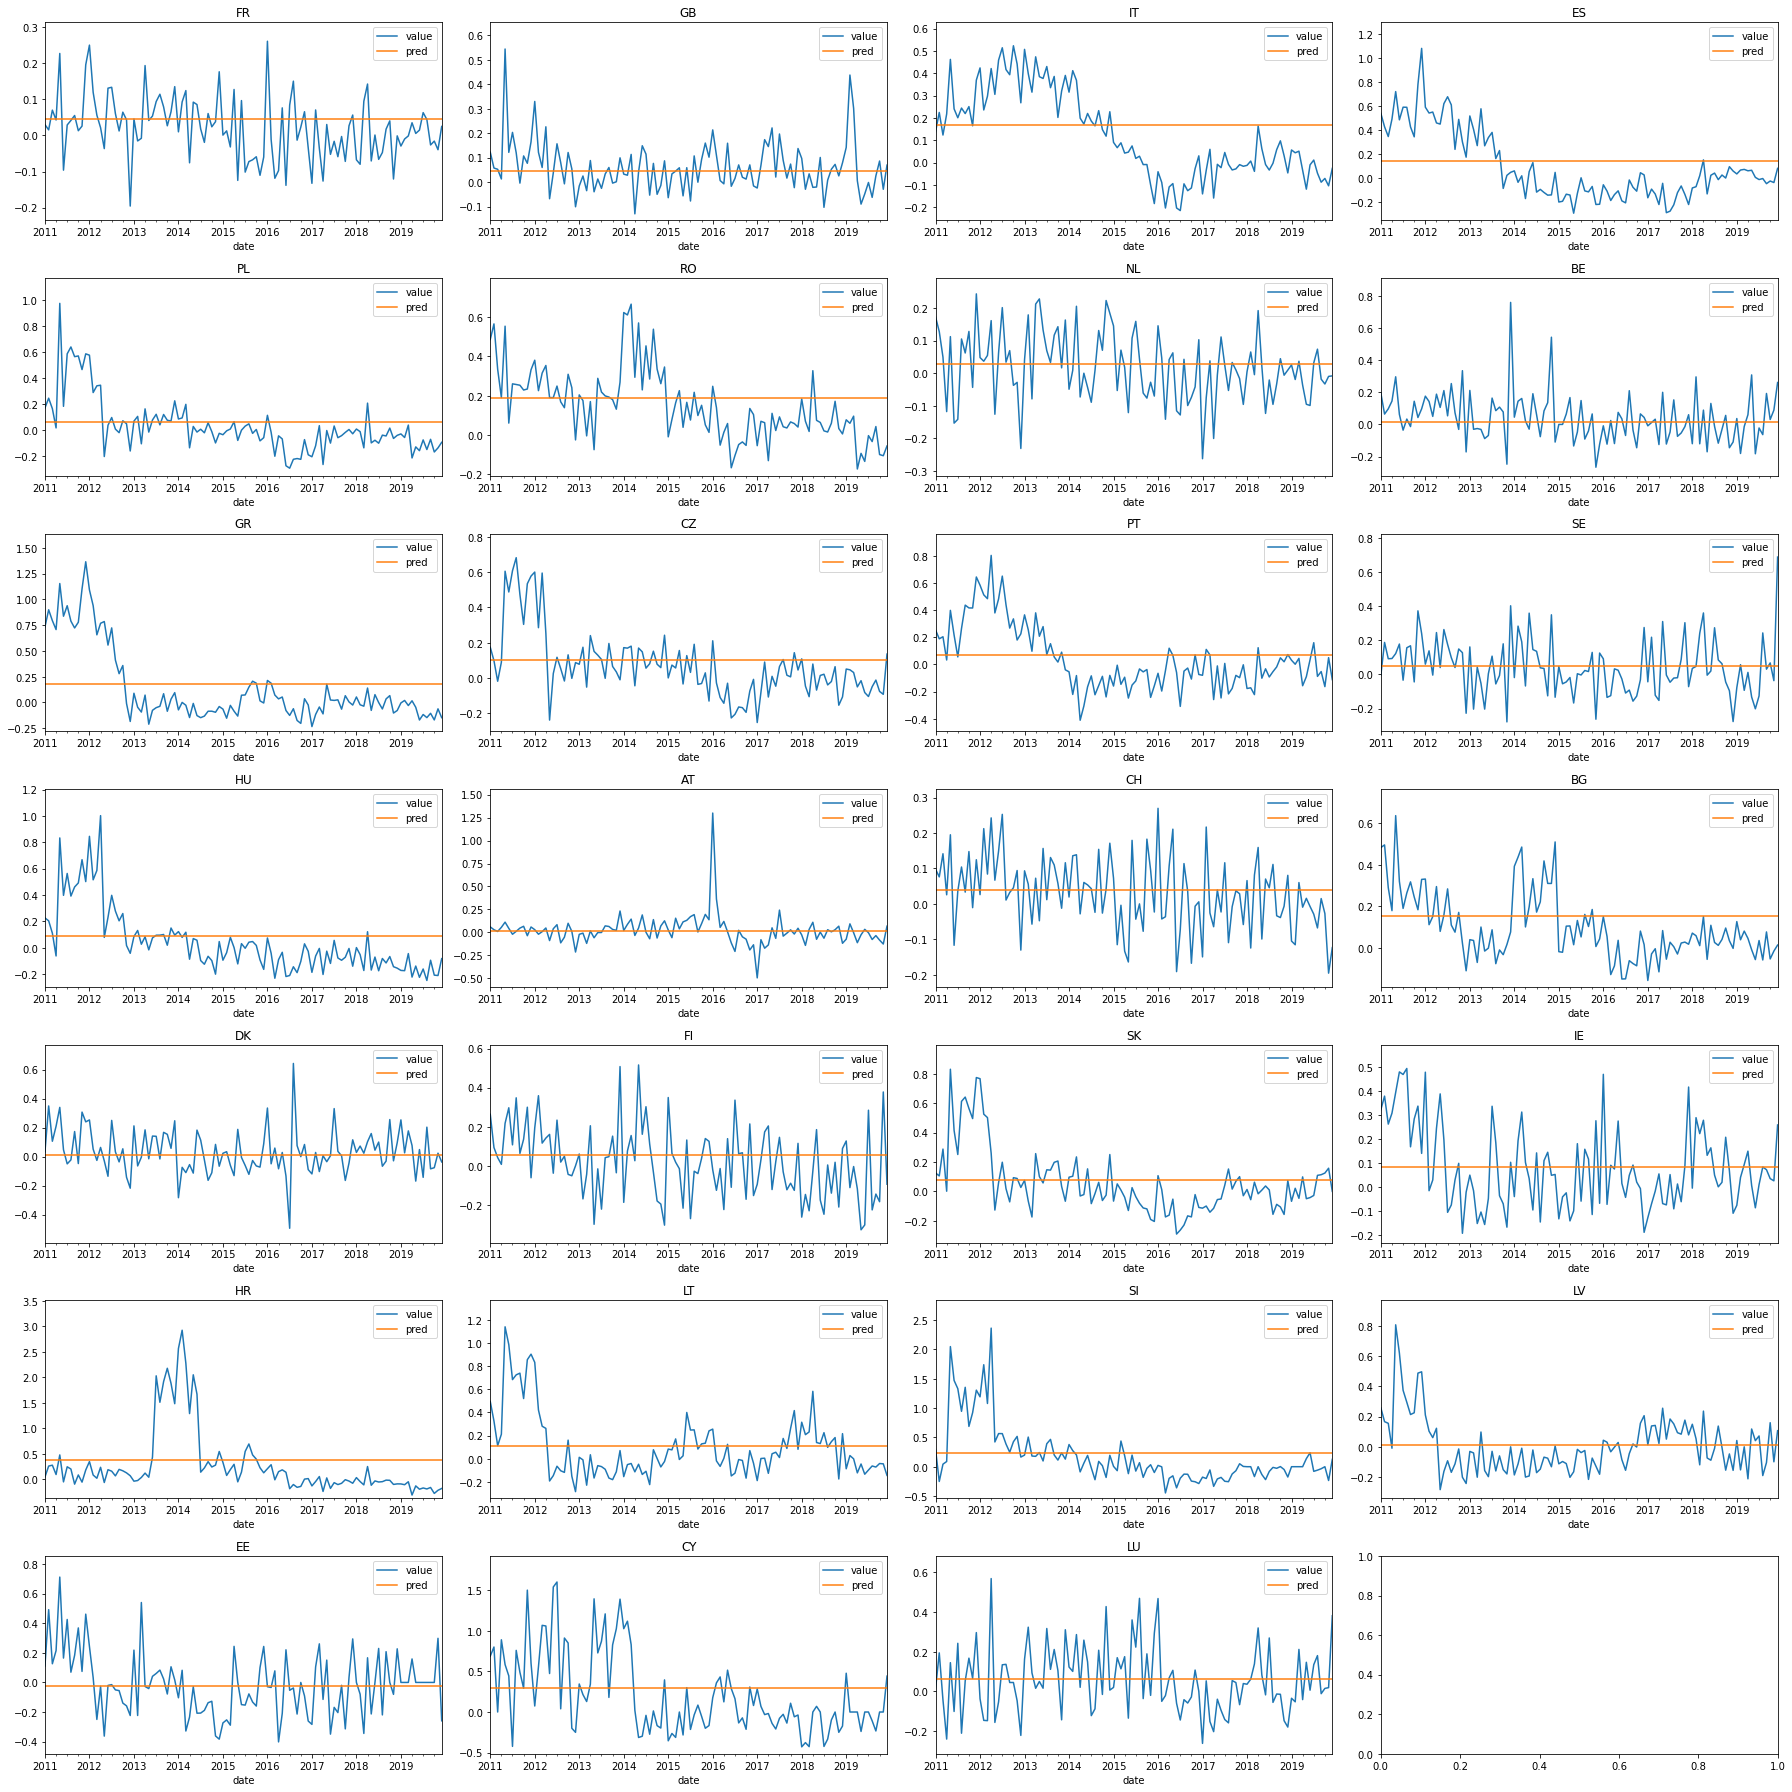

In [7]:
features = dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.007491    0.012617                            -5.487516e+11   
1  0.016195    0.013235                            -1.025703e+12   
2  0.024274    0.022430                            -2.085006e+12   
3  0.017725    0.017323                            -2.322435e+12   
4  0.025448    0.012865                            -9.424600e+11   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.404819 -0.404056  
1                         -0.273522 -0.034751  
2                         -0.348602  0.029151  
3                         -0.165032  0.058747  
4                         -0.133758 -0.100338

Mean CV score:


fit_time                                   1.822672e-02
score_time                                 1.569386e-02
test_neg_mean_absolute_percentage_error   -1.384871e+12
test_neg_root_mean_squared_error          -2.651465e-01
test_r2                                   -9.024935e-02
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.061275e+13
neg_root_mean_squared_error          -1.399903e-01
r2                                   -1.718757e-01
dtype: float64

19       0.157116
19_3     0.056226
19_6     0.037998
19_9     0.041638
19_12    0.112911
dtype: float64

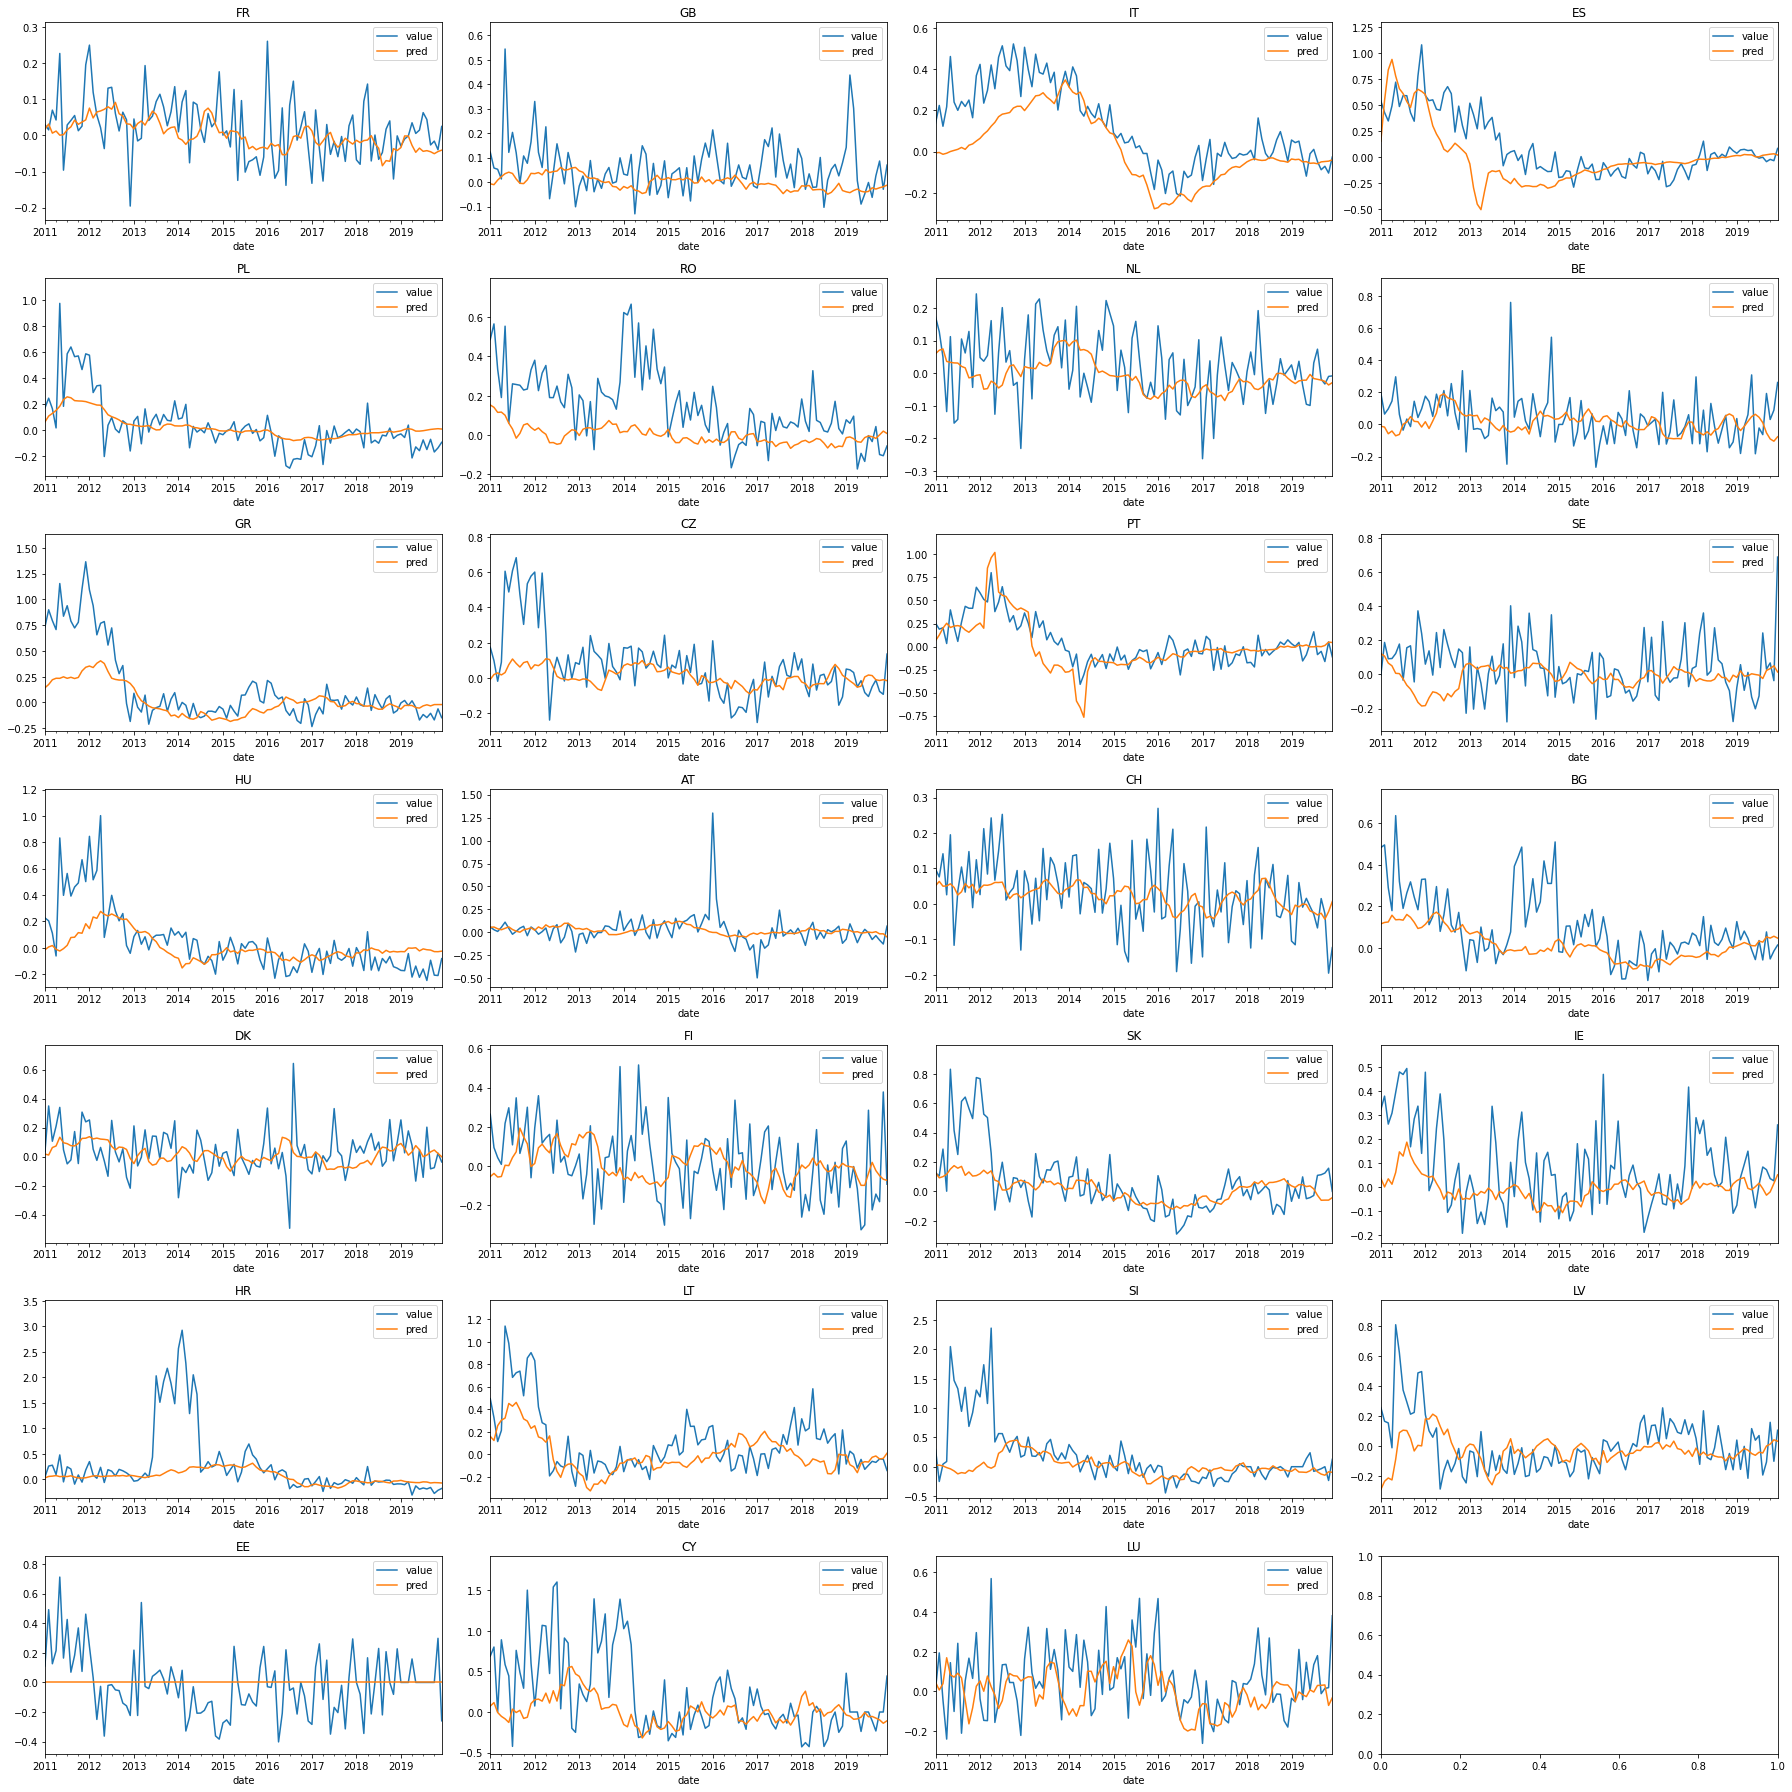

In [8]:
features = ["19", "19_3", "19_6", "19_9", "19_12"]

reg = linear_model.LinearRegression(fit_intercept=False)

# reg = ensemble.GradientBoostingRegressor()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)

display(pd.Series(reg.coef_, index=features))

fig, axs = plot_prediction(reg, x[features])



### plus GTI

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.05913665838047, tolerance: 0.012106274928875158
  model = cd_fast.enet_coordinate_descent(
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.569356      0.036527         0.010408        0.000973         0.0   
1        0.020142      0.001261         0.006498        0.001223    0.000001   
2        0.023755      0.004350         0.007978        0.003239     0.00001   
3        0.022117      0.005107         0.006987        0.002693      0.0001   
4        0.018687      0.002958         0.006554        0.001285       0.001   
5        0.018018      0.001768         0.007278        0.002012        0.01   
6        0.018782      0.004312         0.006798        0.002461       0.002   
7        0.024435      0.005309         0.008406        0.001849       0.005   
8        0.016243      0.001726         0.008094        0.001525         0.1   
9        0.015315      0.004017         0.008217        0.001689         0.2   
10       0.020356      0.003984         0.007932        0.003769         0.5   
11       0.020663      0.002692         0.008274        0.002374         1.0   
12       0.016963      0.002147         0.010111        0.001748         2.0   
13       0.020179      0.001386         0.008033        0.001019         5.0   
14       0.018507      0.004086         0.010339        0.002253        10.0   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.427749          -0.270346          -0.355179   
1           -0.427741          -0.270341          -0.355171   
2           -0.427665          -0.270301          -0.355101   
3           -0.426917          -0.269904          -0.354408   
4           -0.421549          -0.267104          -0.349541   
5           -0.422691          -0.270407          -0.348708   
6           -0.418938          -0.266256          -0.347502   
7           -0.412743          -0.268858          -0.347658   
8           -0.458486          -0.294320          -0.366371   
9           -0.458486          -0.294320          -0.366371   
10          -0.458486          -0.294320          -0.366371   
11          -0.458486          -0.294320          -0.366371   
12          -0.458486          -0.294320          -0.366371   
13          -0.458486          -0.294320          -0.366371   
14          -0.458486          -0.294320          -0.366371   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.188255          -0.176563        -0.283619        0.096567   
1           -0.188240          -0.176547        -0.283608        0.096570   
2           -0.188106          -0.176403        -0.283515        0.096596   
3           -0.186780          -0.174970        -0.282596        0.096861   
4           -0.176245          -0.161922        -0.275272        0.099633   
5           -0.160291          -0.129221        -0.266264        0.110720   
6           -0.168582          -0.151255        -0.270507        0.102555   
7           -0.162376          -0.134149        -0.265157        0.106140   
8           -0.170184          -0.130170        -0.283906        0.121618   
9           -0.170184          -0.130170        -0.283906        0.121618   
10          -0.170184          -0.130170        -0.283906        0.121618   
11          -0.170184          -0.130170        -0.283906        0.121618   
12          -0.170184          -0.130170        -0.283906        0.121618   
13          -0.170184          -0.130170        -0.283906        0.121618   
14          -0.170184          -0.130170        -0.283906        0.121618   

    rank_test_score  
0                 8  
1                 7  
2                 6  
3                 5  
4                 4  
5                 2  
6                 3  
7                 1  
8                 9  
9                 9  
10                9  
11                9  
12                9  
13                9  
14                9

LASSO Coefficients:
19        0.123739
19_12     0.085369
19_3      0.040423
24        0.038201
39        0.031944
19_9      0.028891
19_6      0.028827
21_12     0.028429
24_6      0.025337
24_12     0.019647
11_12     0.017083
24_3      0.016167
48_9      0.016049
21_6      0.014910
12_3      0.011087
21_9      0.010602
58_9      0.009410
113_12    0.007552
12_9      0.005904
48_12     0.005769
49        0.004678
24_9      0.002668
58_12     0.002317
12_12     0.001387
42_9      0.000000
56_9      0.000000
22_9      0.000000
55_9      0.000000
54_9      0.000000
26_9      0.000000
28_9      0.000000
32_9      0.000000
51_9      0.000000
52_9      0.000000
33_9      0.000000
49_9      0.000000
37_9      0.000000
44_9      0.000000
38_9      0.000000
43_9      0.000000
39_9      0.000000
41_9      0.000000
2         0.000000
16_9      0.000000
20_9      0.000000
18_9      0.000000
56_6      0.000000
57_6      0.000000
58_6      0.000000
59_6      0.000000
60_6      0.000000
112_6     0

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.024533    0.010946                            -7.649776e+11   
1  0.021138    0.012851                            -1.337416e+12   
2  0.019874    0.011698                            -3.882235e+12   
3  0.020170    0.010386                            -1.490619e+12   
4  0.021190    0.013544                            -1.361266e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.412743 -0.459564  
1                         -0.268858  0.000243  
2                         -0.347658  0.034400  
3                         -0.162376  0.088797  
4                         -0.134149 -0.106782

Mean CV score:


fit_time                                   2.138119e-02
score_time                                 1.188483e-02
test_neg_mean_absolute_percentage_error   -1.767303e+12
test_neg_root_mean_squared_error          -2.651568e-01
test_r2                                   -8.858142e-02
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -8.311255e+12
neg_root_mean_squared_error          -1.448241e-01
r2                                   -2.542013e-01
dtype: float64

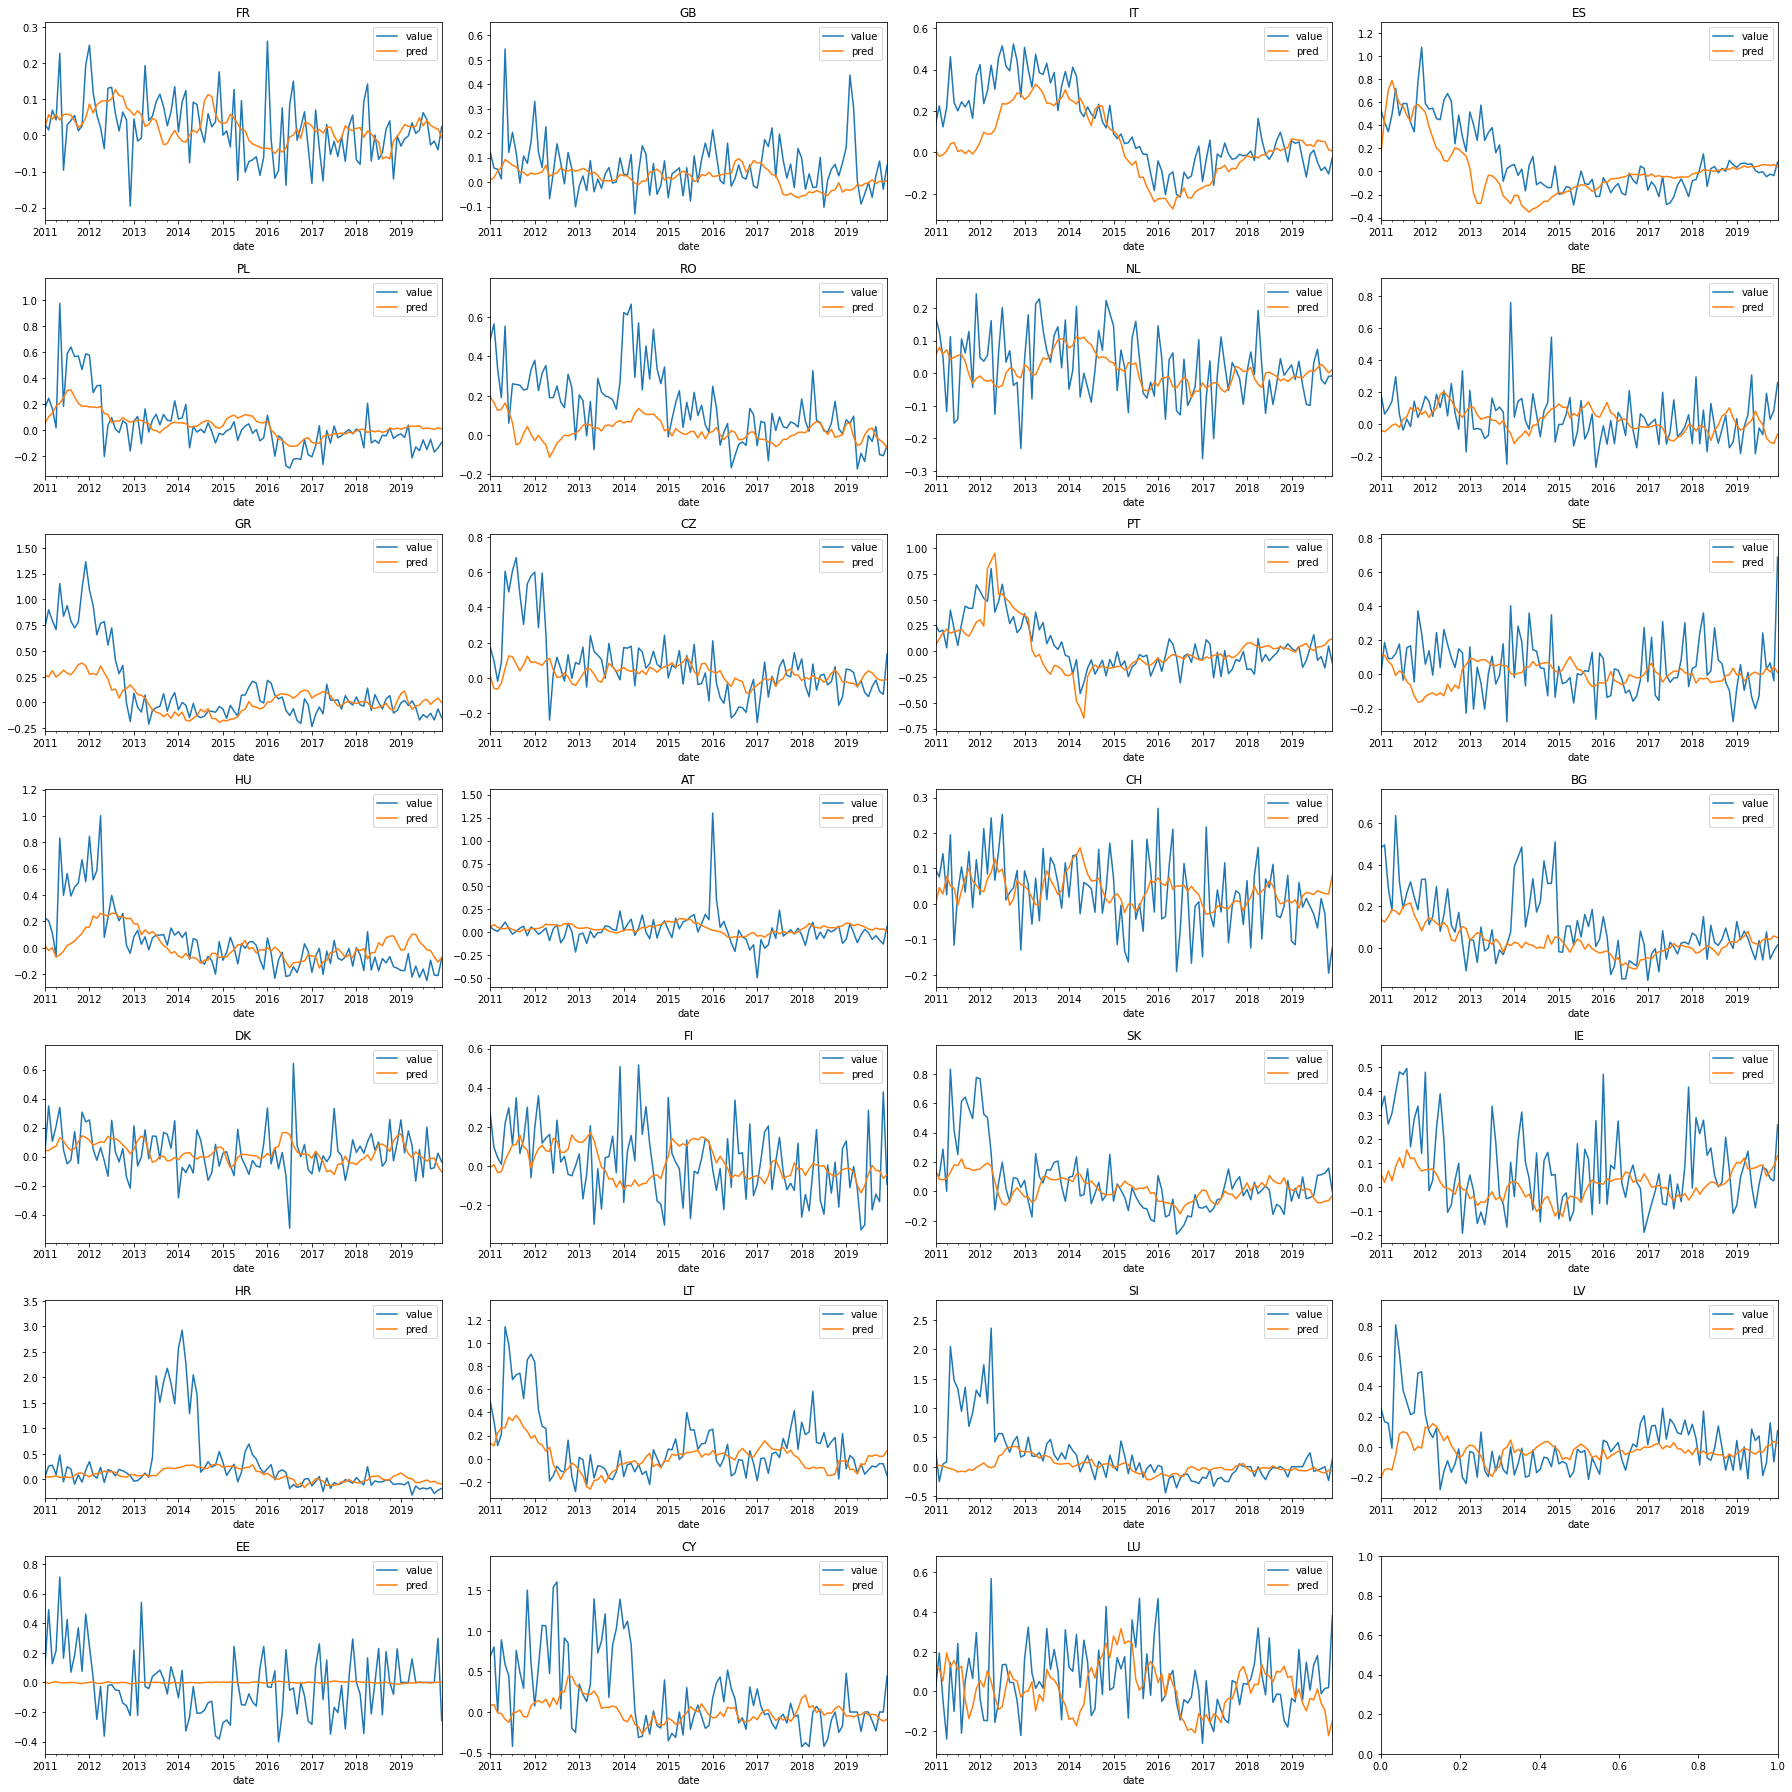

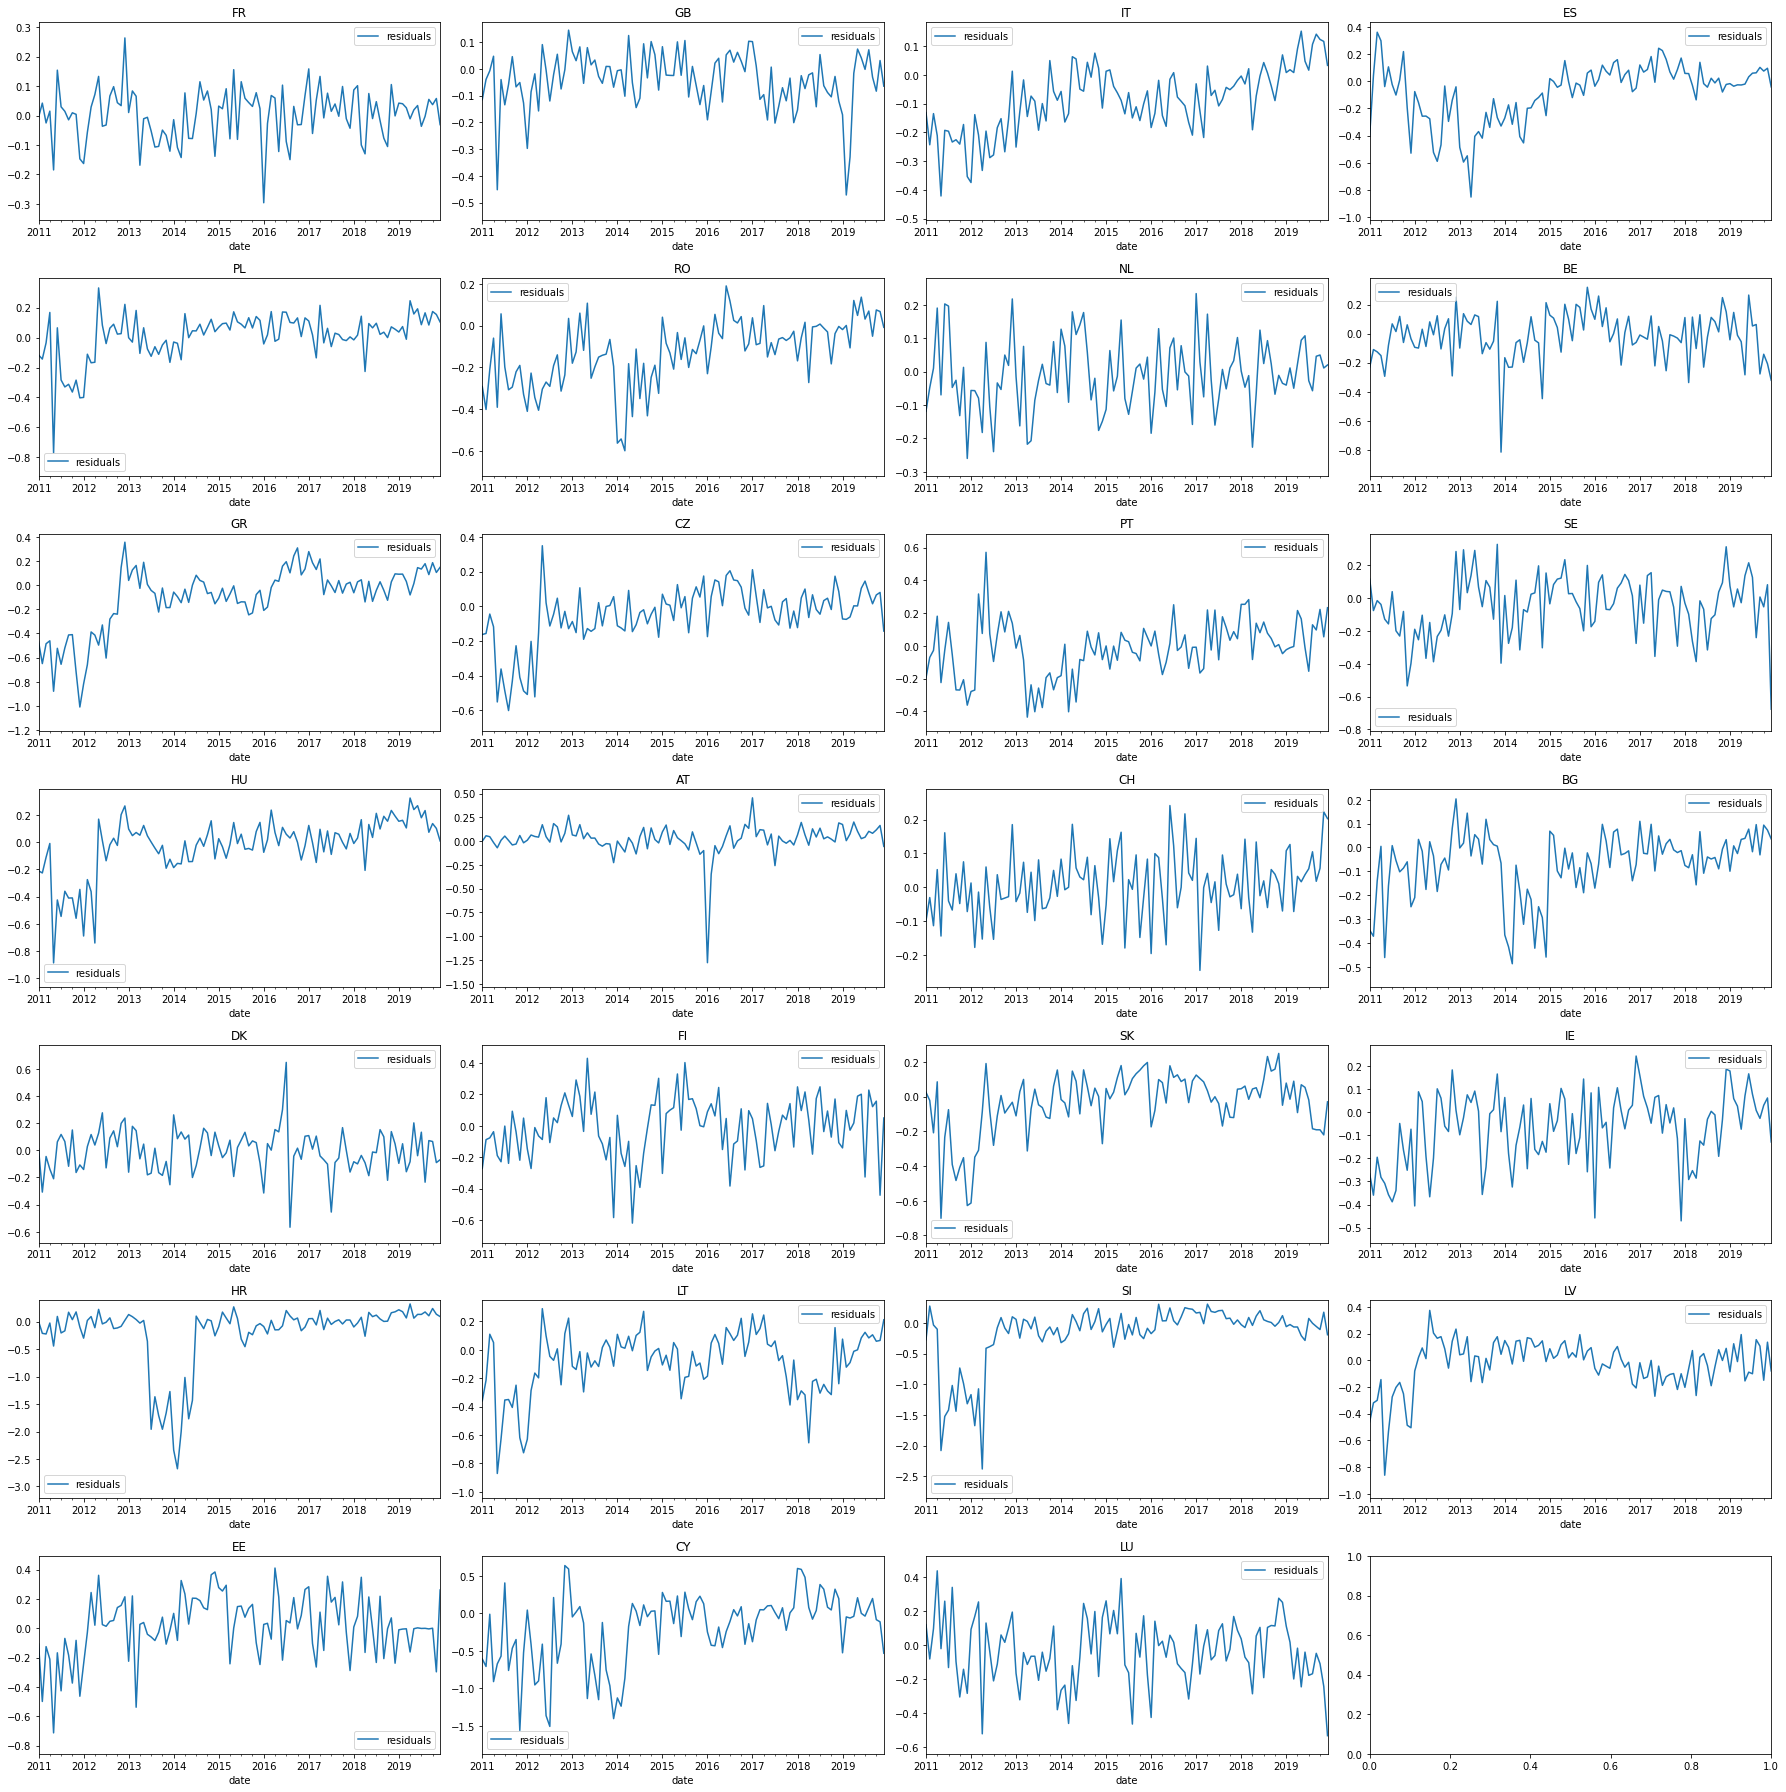

In [9]:
features = (
    keyword_ids
    + [k + "_3" for k in keyword_ids]
    + [k + "_6" for k in keyword_ids]
    + [k + "_9" for k in keyword_ids]
    + [k + "_12" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.Lasso(normalize=False, positive=True, fit_intercept=False)
# reg_unfitted = linear_model.LinearRegression()
params = {
    "alpha": [
        0.0,
        0.000001,
        0.00001,
        0.0001,
        0.001,
        0.01,
        0.002,
        0.005,
        0.1,
        0.2,
        0.5,
        1.0,
        2.0,
        5.0,
        10.0,
    ],
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])



mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.025632      0.003098         0.006731        0.002539       0.001   
1        0.021808      0.004309         0.005475        0.000764       0.001   
2        0.019389      0.002266         0.005606        0.001450       0.001   
3        0.020580      0.003840         0.006276        0.000960       0.001   
4        0.020895      0.005898         0.006289        0.002002        0.01   
5        0.020798      0.003232         0.008897        0.002997        0.01   
6        0.017454      0.003051         0.006458        0.000911        0.01   
7        0.019064      0.002718         0.007438        0.000711        0.01   
8        0.014699      0.001920         0.006338        0.000873         0.1   
9        0.021584      0.003671         0.010194        0.001800         0.1   
10       0.021773      0.004877         0.009411        0.003042         0.1   
11       0.019029      0.001235         0.014409        0.005283         0.1   
12       0.027665      0.006733         0.008785        0.000782         1.0   
13       0.029550      0.004255         0.019233        0.017265         1.0   
14       0.039086      0.024785         0.013651        0.006198         1.0   
15       0.025518      0.009847         0.008905        0.002682         1.0   

   param_l1_ratio  split0_test_score  split1_test_score  split2_test_score  \
0             0.5          -0.425113          -0.292753          -0.342624   
1             0.8          -0.419770          -0.283461          -0.341044   
2             0.9          -0.418439          -0.281192          -0.340726   
3            0.95          -0.417904          -0.280382          -0.340593   
4             0.5          -0.413934          -0.266383          -0.345608   
5             0.8          -0.417907          -0.268543          -0.346730   
6             0.9          -0.420225          -0.268950          -0.347366   
7            0.95          -0.421399          -0.269257          -0.347653   
8             0.5          -0.458486          -0.294147          -0.366177   
9             0.8          -0.458486          -0.294320          -0.366371   
10            0.9          -0.458486          -0.294320          -0.366371   
11           0.95          -0.458486          -0.294320          -0.366371   
12            0.5          -0.458486          -0.294320          -0.366371   
13            0.8          -0.458486          -0.294320          -0.366371   
14            0.9          -0.458486          -0.294320          -0.366371   
15           0.95          -0.458486          -0.294320          -0.366371   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           -0.216886          -0.215145        -0.298504        0.079523   
1           -0.210405          -0.202349        -0.291406        0.081849   
2           -0.208340          -0.198573        -0.289454        0.082671   
3           -0.207374          -0.196830        -0.288617        0.083078   
4           -0.168566          -0.137636        -0.266425        0.104107   
5           -0.164124          -0.132094        -0.265880        0.107619   
6           -0.163552          -0.131070        -0.266233        0.108735   
7           -0.163326          -0.130681        -0.266463        0.109251   
8           -0.169228          -0.129567        -0.283521        0.121920   
9           -0.170184          -0.130170        -0.283906        0.121618   
10          -0.170184          -0.130170        -0.283906        0.121618   
11          -0.170184          -0.130170        -0.283906        0.121618   
12          -0.170184          -0.130170        -0.283906        0.121618   
13          -0.170184          -0.130170        -0.283906        0.121618   
14          -0.170184          -0.130170        -0.283906        0.121618   
15          -0.170184          -0.130170        -0.283906        0.121618   

    ra

LASSO Coefficients:
19        0.118351
19_12     0.077931
19_3      0.042588
19_9      0.029856
19_6      0.029116
24        0.025477
21_12     0.020520
24_6      0.020266
24_12     0.013333
24_3      0.011818
48_9      0.010002
11_12     0.006057
12_3      0.005237
21_6      0.004095
12_9      0.001380
58_9      0.000999
21_9      0.000391
118_6    -0.000000
42_9      0.000000
28_9      0.000000
32_9      0.000000
33_9      0.000000
37_9     -0.000000
58_6      0.000000
38_9      0.000000
39_9      0.000000
41_9     -0.000000
57_6     -0.000000
43_9      0.000000
24_9      0.000000
44_9      0.000000
56_6     -0.000000
49_9      0.000000
55_6     -0.000000
51_9      0.000000
52_9      0.000000
54_9      0.000000
55_9     -0.000000
56_9     -0.000000
57_9     -0.000000
26_9      0.000000
59_6      0.000000
119_6    -0.000000
11_9      0.000000
117_6     0.000000
121_6    -0.000000
115_6    -0.000000
122_6    -0.000000
123_6    -0.000000
124_6     0.000000
125_6     0.000000
2_9       0

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.021325    0.009279                            -6.555090e+11   
1  0.062186    0.018328                            -1.167487e+12   
2  0.047345    0.026340                            -2.881933e+12   
3  0.032979    0.013252                            -1.650145e+12   
4  0.021729    0.009229                            -1.277763e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.417907 -0.496316  
1                         -0.268543  0.002580  
2                         -0.346730  0.039550  
3                         -0.164124  0.069076  
4                         -0.132094 -0.073137

Mean CV score:


fit_time                                   3.711281e-02
score_time                                 1.528554e-02
test_neg_mean_absolute_percentage_error   -1.526567e+12
test_neg_root_mean_squared_error          -2.658797e-01
test_r2                                   -9.164948e-02
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -8.782028e+12
neg_root_mean_squared_error          -1.390070e-01
r2                                   -1.554715e-01
dtype: float64

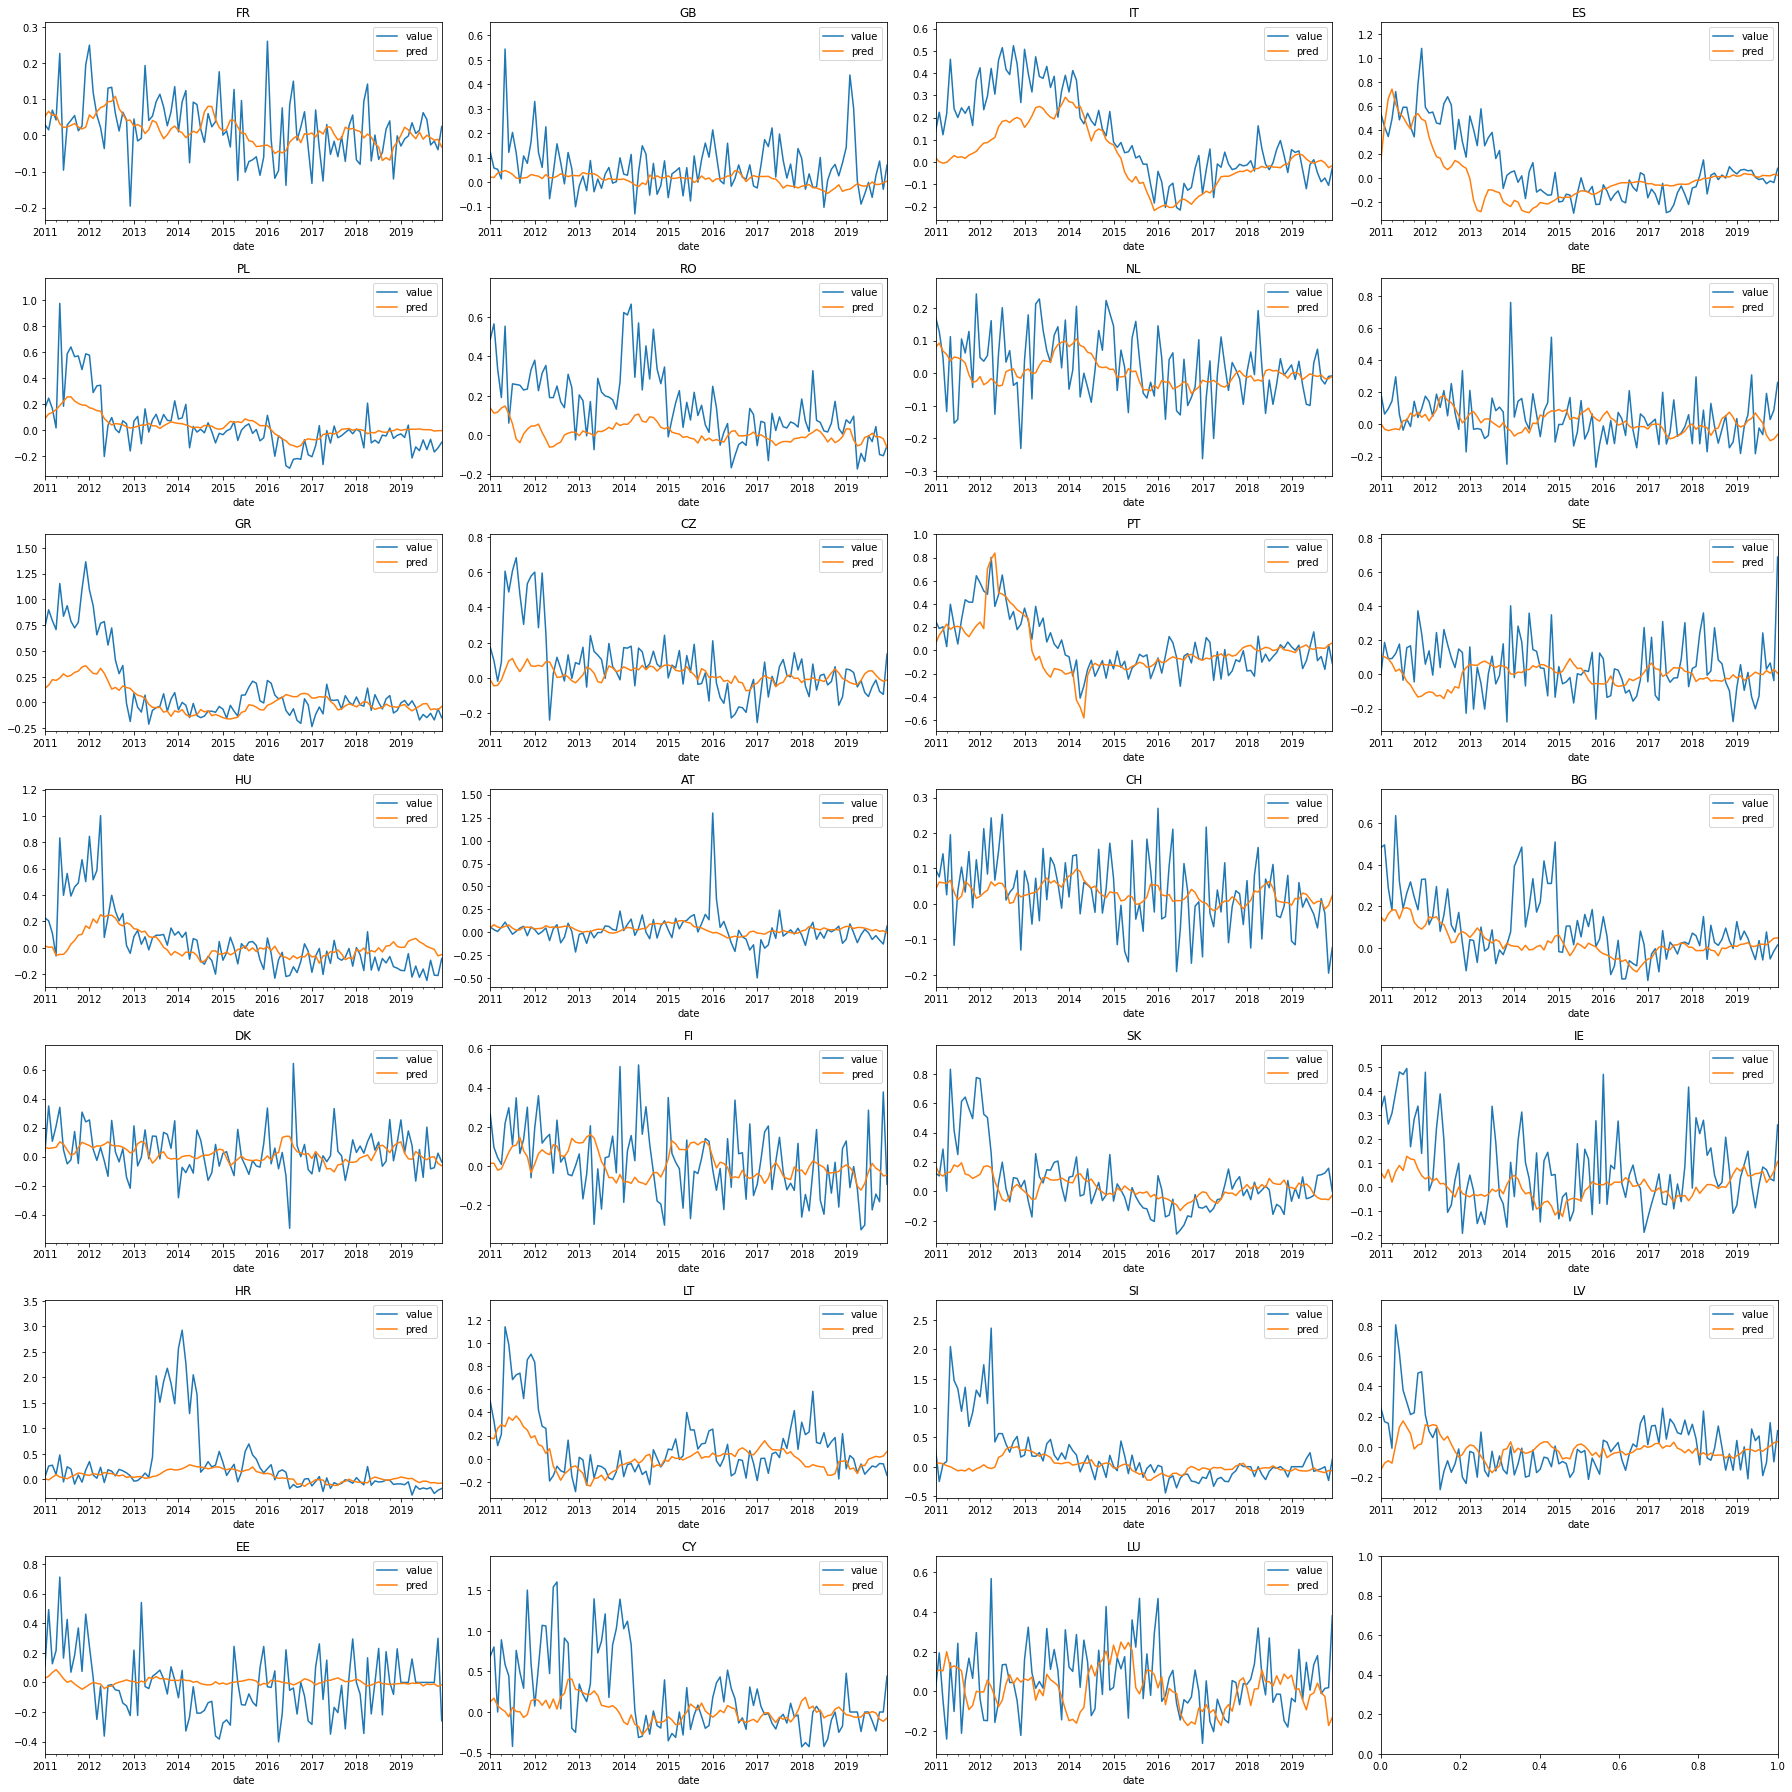

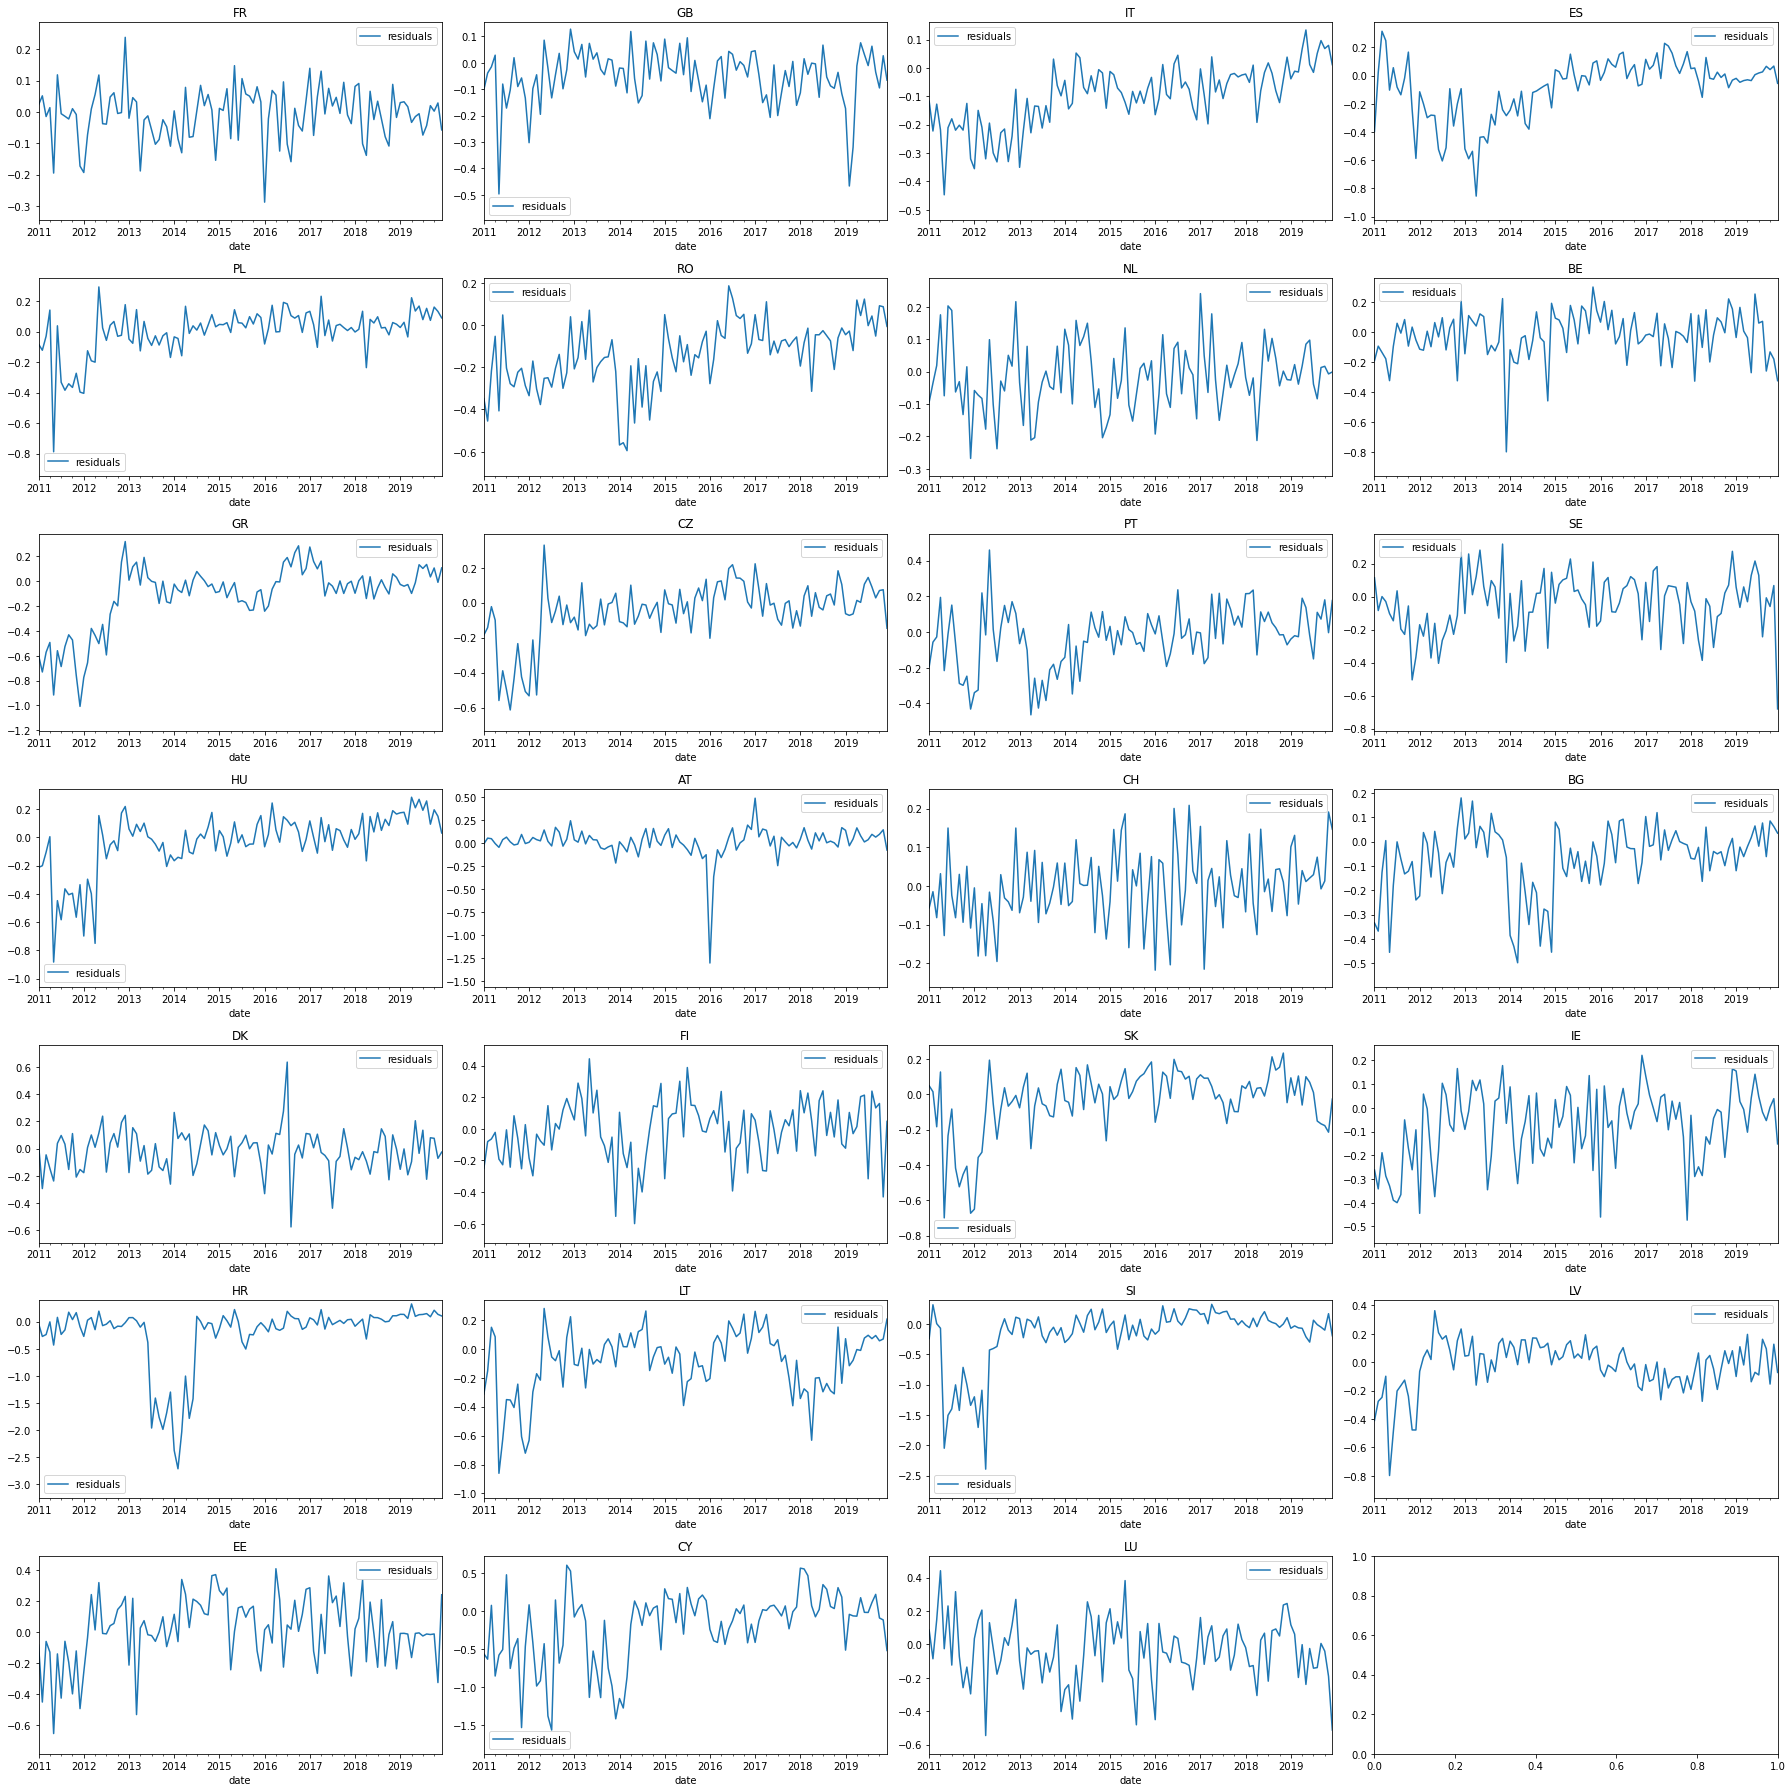

In [10]:
features = (
    keyword_ids
    + [k + "_3" for k in keyword_ids]
    + [k + "_6" for k in keyword_ids]
    + [k + "_9" for k in keyword_ids]
    + [k + "_12" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.ElasticNet(normalize=False, fit_intercept=False)
# reg_unfitted = linear_model.LinearRegression()
params = {
    "alpha": [
        0.001,
        0.01,
        0.1,
        1.0,
    ],
    "l1_ratio": [0.5, 0.8, 0.9, 0.95]
}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.088536      0.012831         0.008375        0.001263   
1        0.088563      0.011752         0.008826        0.001076   
2        0.097567      0.016759         0.011426        0.002888   
3        0.124490      0.026018         0.010794        0.002186   
4        0.125265      0.018872         0.010551        0.001102   
5        0.156622      0.024125         0.015818        0.002098   
6        0.137963      0.074069         0.011133        0.002533   
7        0.103244      0.009741         0.009432        0.002192   
8        0.095940      0.005896         0.009766        0.002089   
9        0.089097      0.009017         0.008671        0.000618   
10       0.098016      0.017025         0.007976        0.001457   
11       0.112845      0.011786         0.011915        0.001600   
12       0.109708      0.008043         0.009503        0.002057   
13       0.101448      0.007037         0.010579        0.001105   
14       0.123662      0.014814         0.011063        0.001074   
15       0.116258      0.019194         0.010681        0.001966   
16       0.107997      0.009276         0.011000        0.001147   
17       0.145671      0.067985         0.010806        0.002345   
18       0.097226      0.008384         0.009178        0.002340   
19       0.088100      0.005943         0.008825        0.001561   

   param_lambda_2 param_lambda_1 param_alpha_2 param_alpha_1  \
0           0.001         0.0001        0.0001          0.01   
1           0.001            0.1         0.001        0.0001   
2             0.1          0.001           0.1           0.1   
3          0.0001       0.000001      0.000001         0.001   
4          0.0001       0.000001         0.001      0.000001   
5          0.0001          0.001        0.0001         0.001   
6        0.000001            0.1         0.001      0.000001   
7            0.01           0.01        0.0001           0.1   
8          0.0001         0.0001        0.0001         0.001   
9           0.001          0.001          0.01        0.0001   
10       0.000001           0.01          0.01           0.1   
11           0.01           0.01        0.0001          0.01   
12            0.1            0.1      0.000001        0.0001   
13            0.1            0.1          0.01           0.1   
14          0.001       0.000001        0.0001      0.000001   
15           0.01            0.1      0.000001        0.0001   
16       0.000001           0.01          0.01          0.01   
17           0.01          0.001           0.1          0.01   
18       0.000001         0.0001      0.000001          0.01   
19           0.01         0.0001      0.000001        0.0001   

    split0_test_score  split1_test_score  split2_test_score  \
0           -0.418164          -0.252886          -0.332167   
1           -0.418156          -0.252891          -0.332183   
2           -0.420229          -0.252501          -0.327349   
3           -0.418112          -0.252921          -0.332298   
4           -0.418112          -0.252921          -0.332298   
5           -0.418112          -0.252921          -0.332298   
6           -0.418098          -0.252931          -0.332329   
7           -0.418605          -0.252624          -0.331136   
8           -0.418112          -0.252921          -0.332298   
9           -0.418162          -0.252887          -0.332171   
10          -0.418104          -0.252926          -0.332316   
11          -0.418605          -0.252625          -0.331138   
12          -0.420235          -0.252504          -0.327338   
13          -0.420234          -0.252504          -0.327339   
14          -0.418164          -0.252886          -0.332167   
15          -0.418599          -0.252628          -0.331149   
16          -0.418103          -0.252927          -0.332318   
17          -0.418585          -0.252632          -0.331167   
18          -0.418106          -0

LASSO Coefficients:
CY        0.202171
HR        0.175886
SI        0.159295
RO        0.132190
GR        0.124351
19        0.101343
39        0.091898
123       0.079804
IT        0.079692
ES        0.068892
19_12     0.066054
117_6     0.064717
119       0.062524
IE        0.062451
HU        0.057547
39_12     0.056989
115_3     0.054117
123_3     0.051140
19_3      0.050744
BG        0.050471
24        0.046161
SE        0.045797
124       0.045762
113_12    0.044445
115_12    0.041338
LU        0.040634
CZ        0.039345
115_6     0.037022
LT        0.036419
19_6      0.036094
19_9      0.036067
39_9      0.034292
39_3      0.033288
39_6      0.032898
21_12     0.032871
112       0.032339
FI        0.031435
37        0.026870
121_12    0.025939
PT        0.025433
21_6      0.024935
GB        0.024086
49_9      0.024047
58_9      0.023990
2         0.023820
24_6      0.023547
16_9      0.023396
48_9      0.023252
122_9     0.022347
16_6      0.022209
112_6     0.021790
26_9      0

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  0.098748    0.008960                            -3.171719e+12   
1  0.107668    0.013513                            -1.314324e+12   
2  0.117061    0.012913                            -3.233809e+12   
3  0.096305    0.009375                            -2.647367e+12   
4  0.098978    0.013316                            -2.993644e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.418098 -0.497679  
1                         -0.252931  0.115181  
2                         -0.332329  0.117674  
3                         -0.216356 -0.617745  
4                         -0.234573 -2.384086

Mean CV score:


fit_time                                   1.037521e-01
score_time                                 1.161556e-02
test_neg_mean_absolute_percentage_error   -2.672173e+12
test_neg_root_mean_squared_error          -2.908573e-01
test_r2                                   -6.533312e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -2.106304e+13
neg_root_mean_squared_error          -1.947085e-01
r2                                   -1.267022e+00
dtype: float64

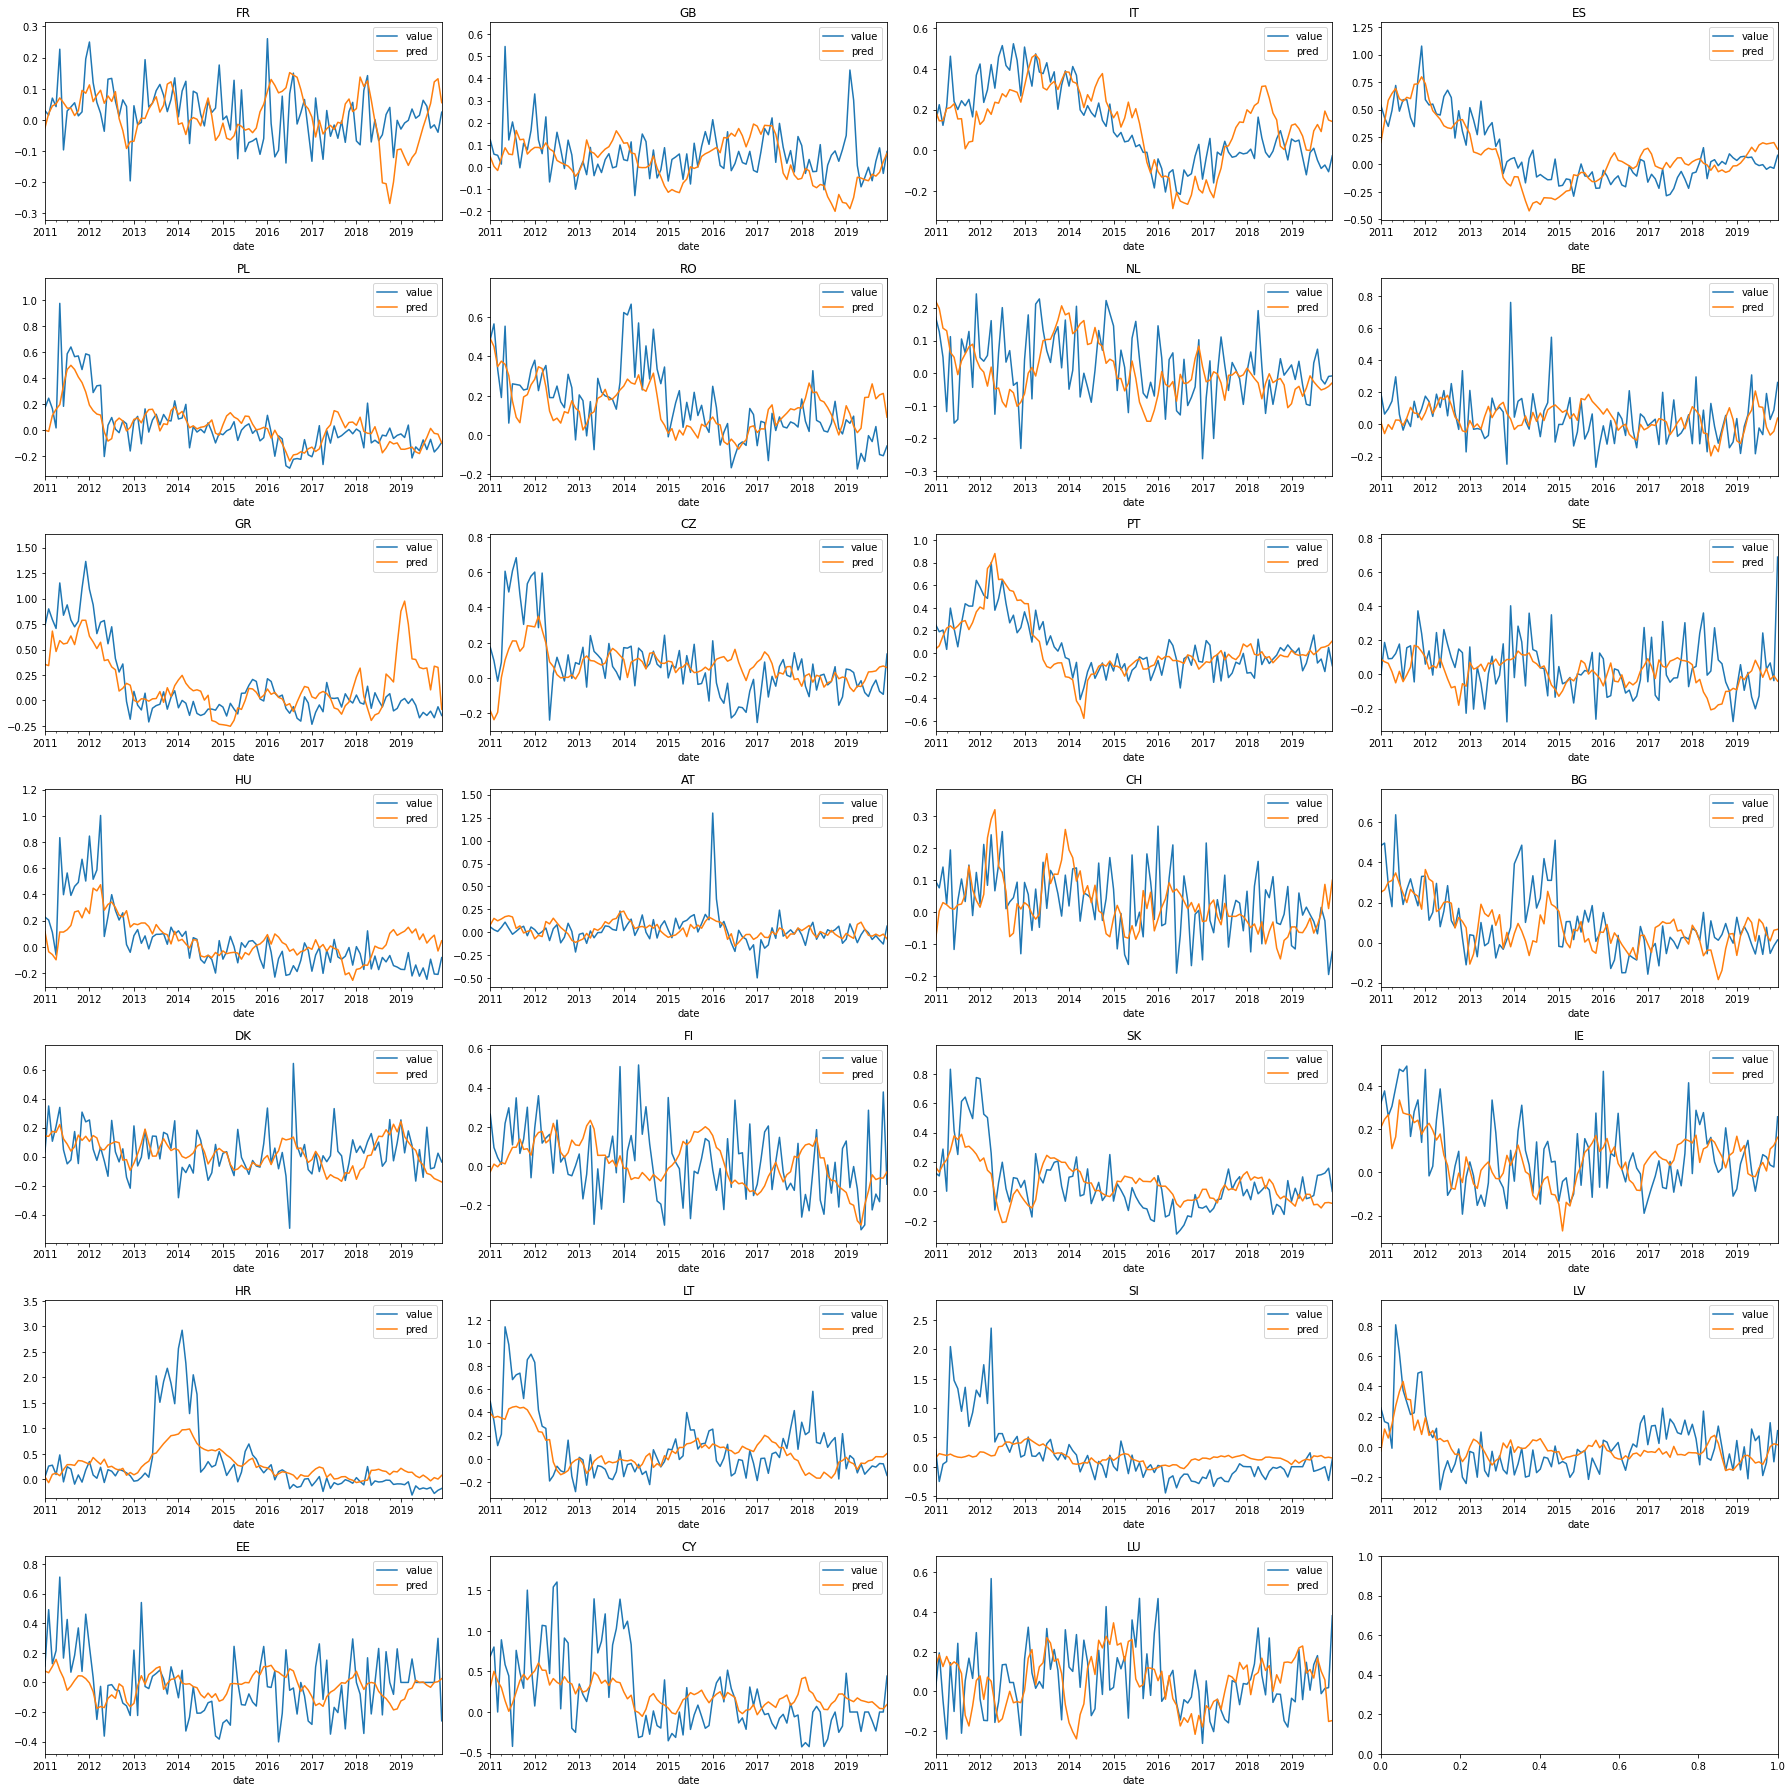

In [11]:
features = (
    dummy_cols
    + keyword_ids
    + [k + "_3" for k in keyword_ids]
    + [k + "_6" for k in keyword_ids]
    + [k + "_9" for k in keyword_ids]
    + [k + "_12" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = linear_model.BayesianRidge(fit_intercept=False)
params = {
    "alpha_1": [1e-6, 1e-4, 1e-3, 1e-2, 0.1],
    "alpha_2": [1e-6, 1e-4, 1e-3, 1e-2, 0.1],
    "lambda_1": [1e-6, 1e-4, 1e-3, 1e-2, 0.1],
    "lambda_2": [1e-6, 1e-4, 1e-3, 1e-2, 0.1],
}
tuner = model_selection.RandomizedSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error", n_iter=20
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

lasso_coefs = reg.coef_
print("LASSO Coefficients:")
print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
# fig, axs = plot_residuals(reg, x[features])



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       7.747438      2.268426         0.014979        0.005252   
1       7.056040      0.359971         0.011595        0.002872   
2       5.627710      0.744112         0.012043        0.002779   
3       3.654715      0.360782         0.011517        0.002706   
4       3.381855      1.001254         0.010449        0.000913   

  param_mlpregressor__alpha  split0_test_score  split1_test_score  \
0                       0.1          -0.597769          -0.390774   
1                       0.3          -0.435668          -0.263481   
2                       1.0          -0.406573          -0.262720   
3                       3.0          -0.384876          -0.254047   
4                      10.0          -0.400551          -0.239823   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0          -0.341953          -0.404862          -0.374049        -0.421881   
1          -0.295419          -0.253030          -0.237108        -0.296941   
2          -0.305183          -0.260696          -0.227824        -0.292599   
3          -0.303495          -0.221151          -0.216356        -0.275985   
4          -0.329691          -0.201997          -0.210911        -0.276595   

   std_test_score  rank_test_score  
0        0.090410                5  
1        0.071938                4  
2        0.062056                3  
3        0.062702                1  
4        0.076701                2

fit_time  score_time  test_neg_mean_absolute_percentage_error  \
0  3.601548    0.017707                            -4.023971e+12   
1  3.322636    0.010192                            -6.568943e+11   
2  3.059879    0.011289                            -6.035375e+12   
3  4.313490    0.014307                            -2.160078e+12   
4  4.380218    0.010437                            -2.036570e+12   

   test_neg_root_mean_squared_error   test_r2  
0                         -0.389540 -0.300071  
1                         -0.230612  0.264448  
2                         -0.297035  0.295134  
3                         -0.227858 -0.794319  
4                         -0.212152 -1.768093

Mean CV score:


fit_time                                   3.735554e+00
score_time                                 1.278653e-02
test_neg_mean_absolute_percentage_error   -2.982578e+12
test_neg_root_mean_squared_error          -2.714392e-01
test_r2                                   -4.605800e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.517481e+13
neg_root_mean_squared_error          -1.934825e-01
r2                                   -1.238564e+00
dtype: float64

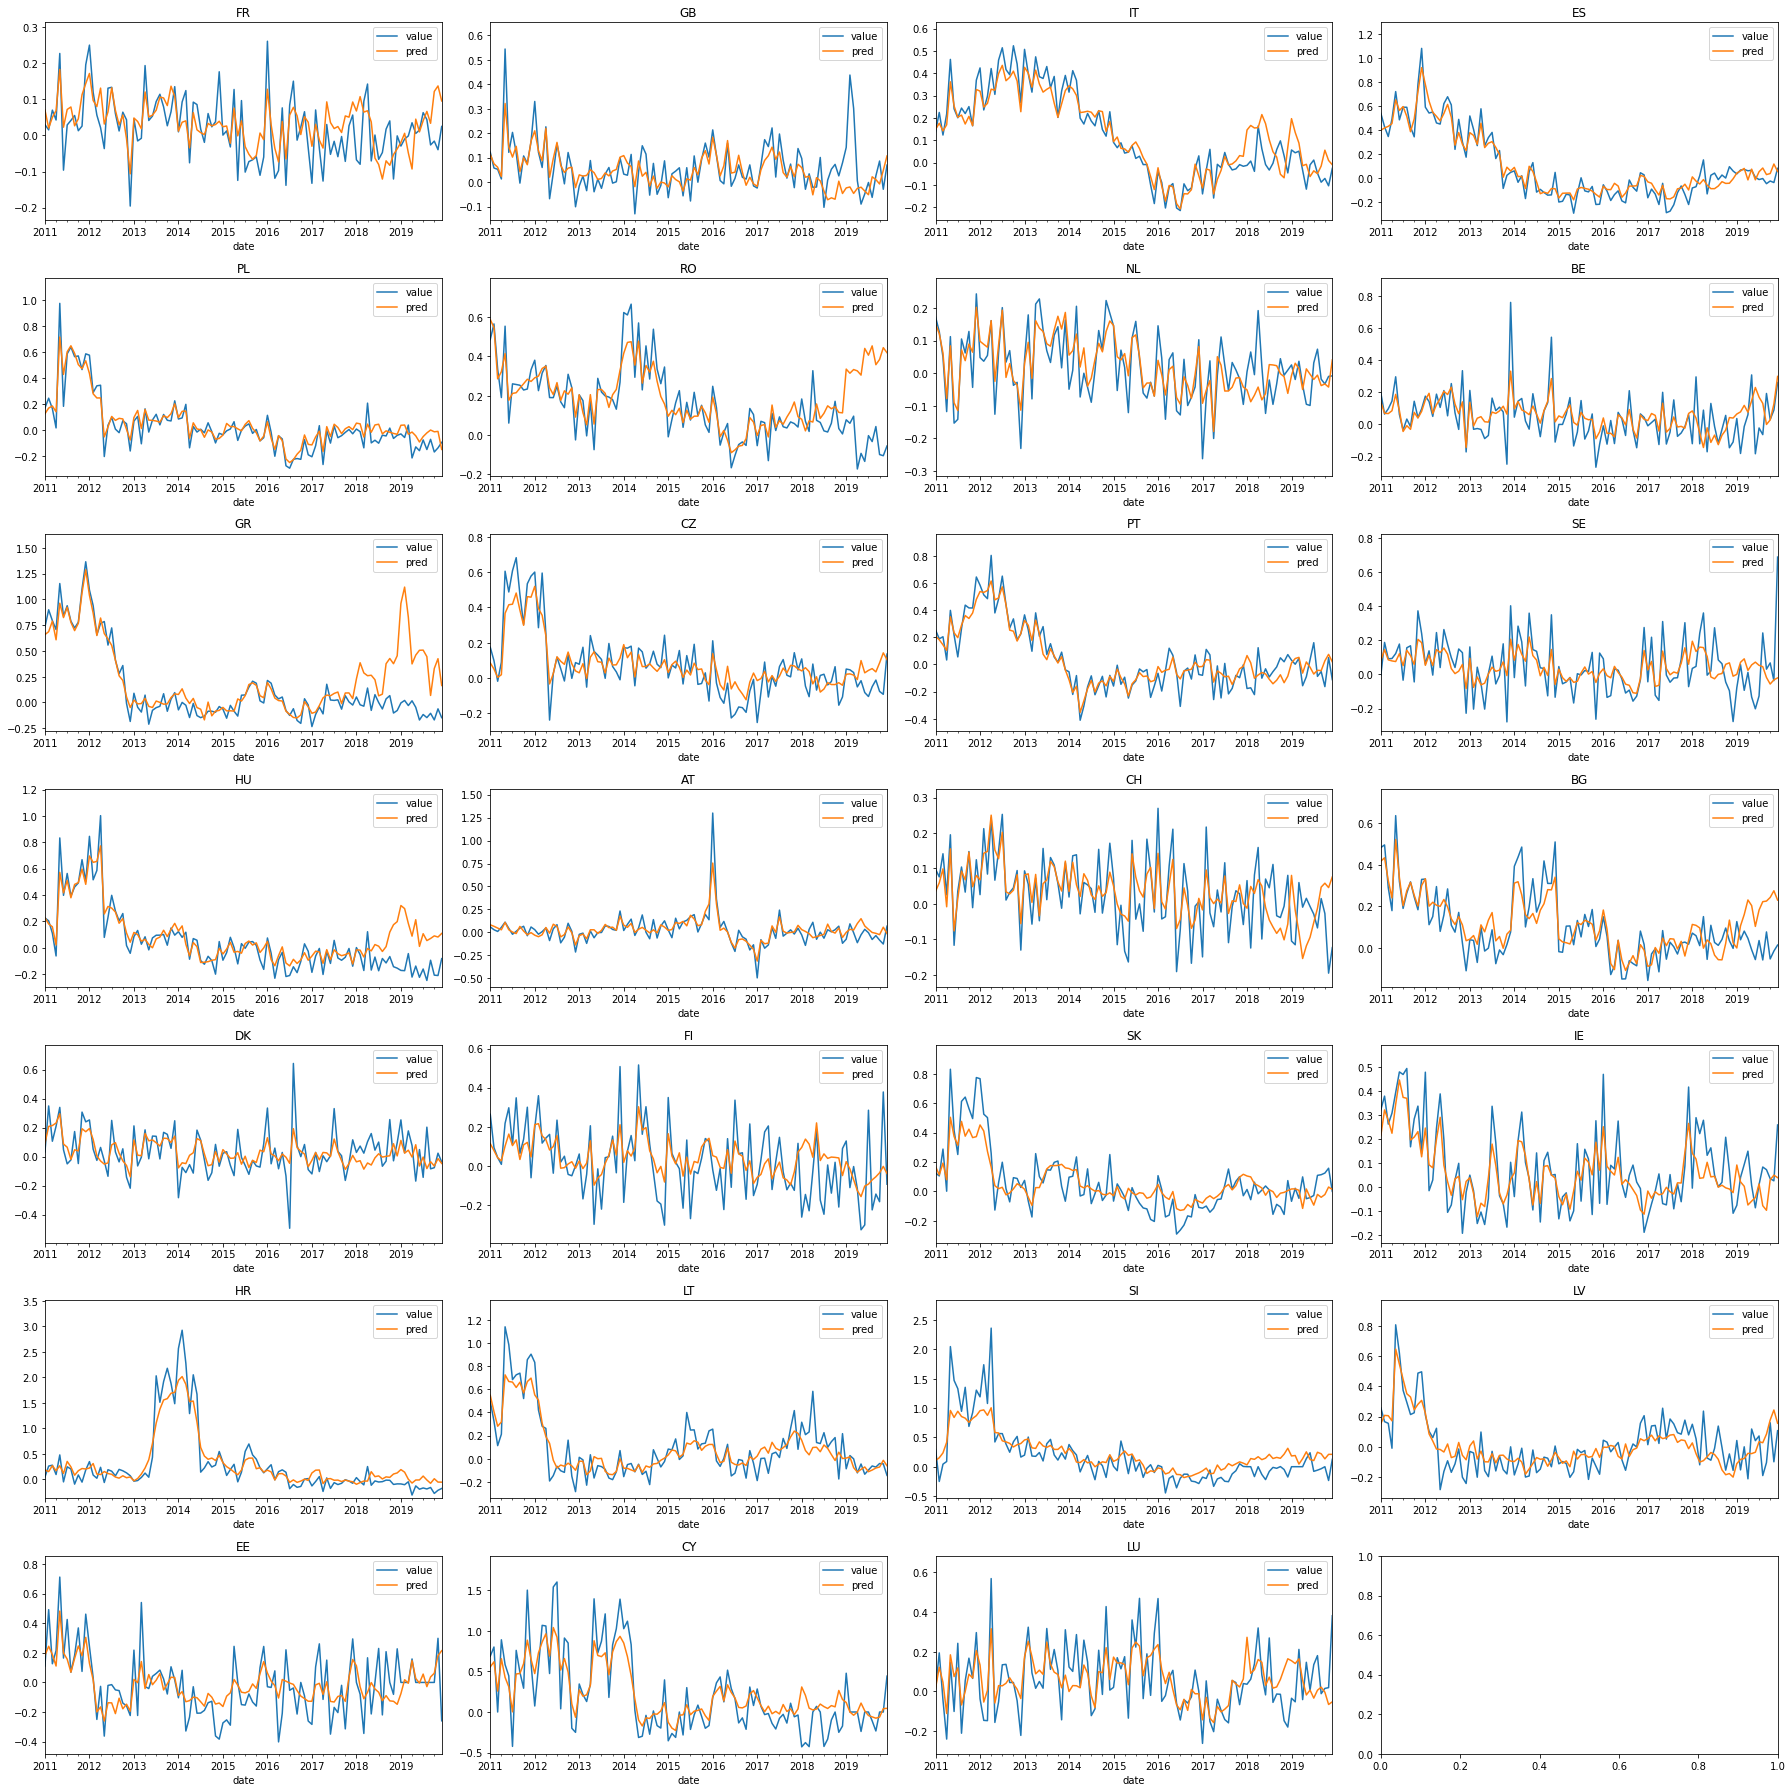

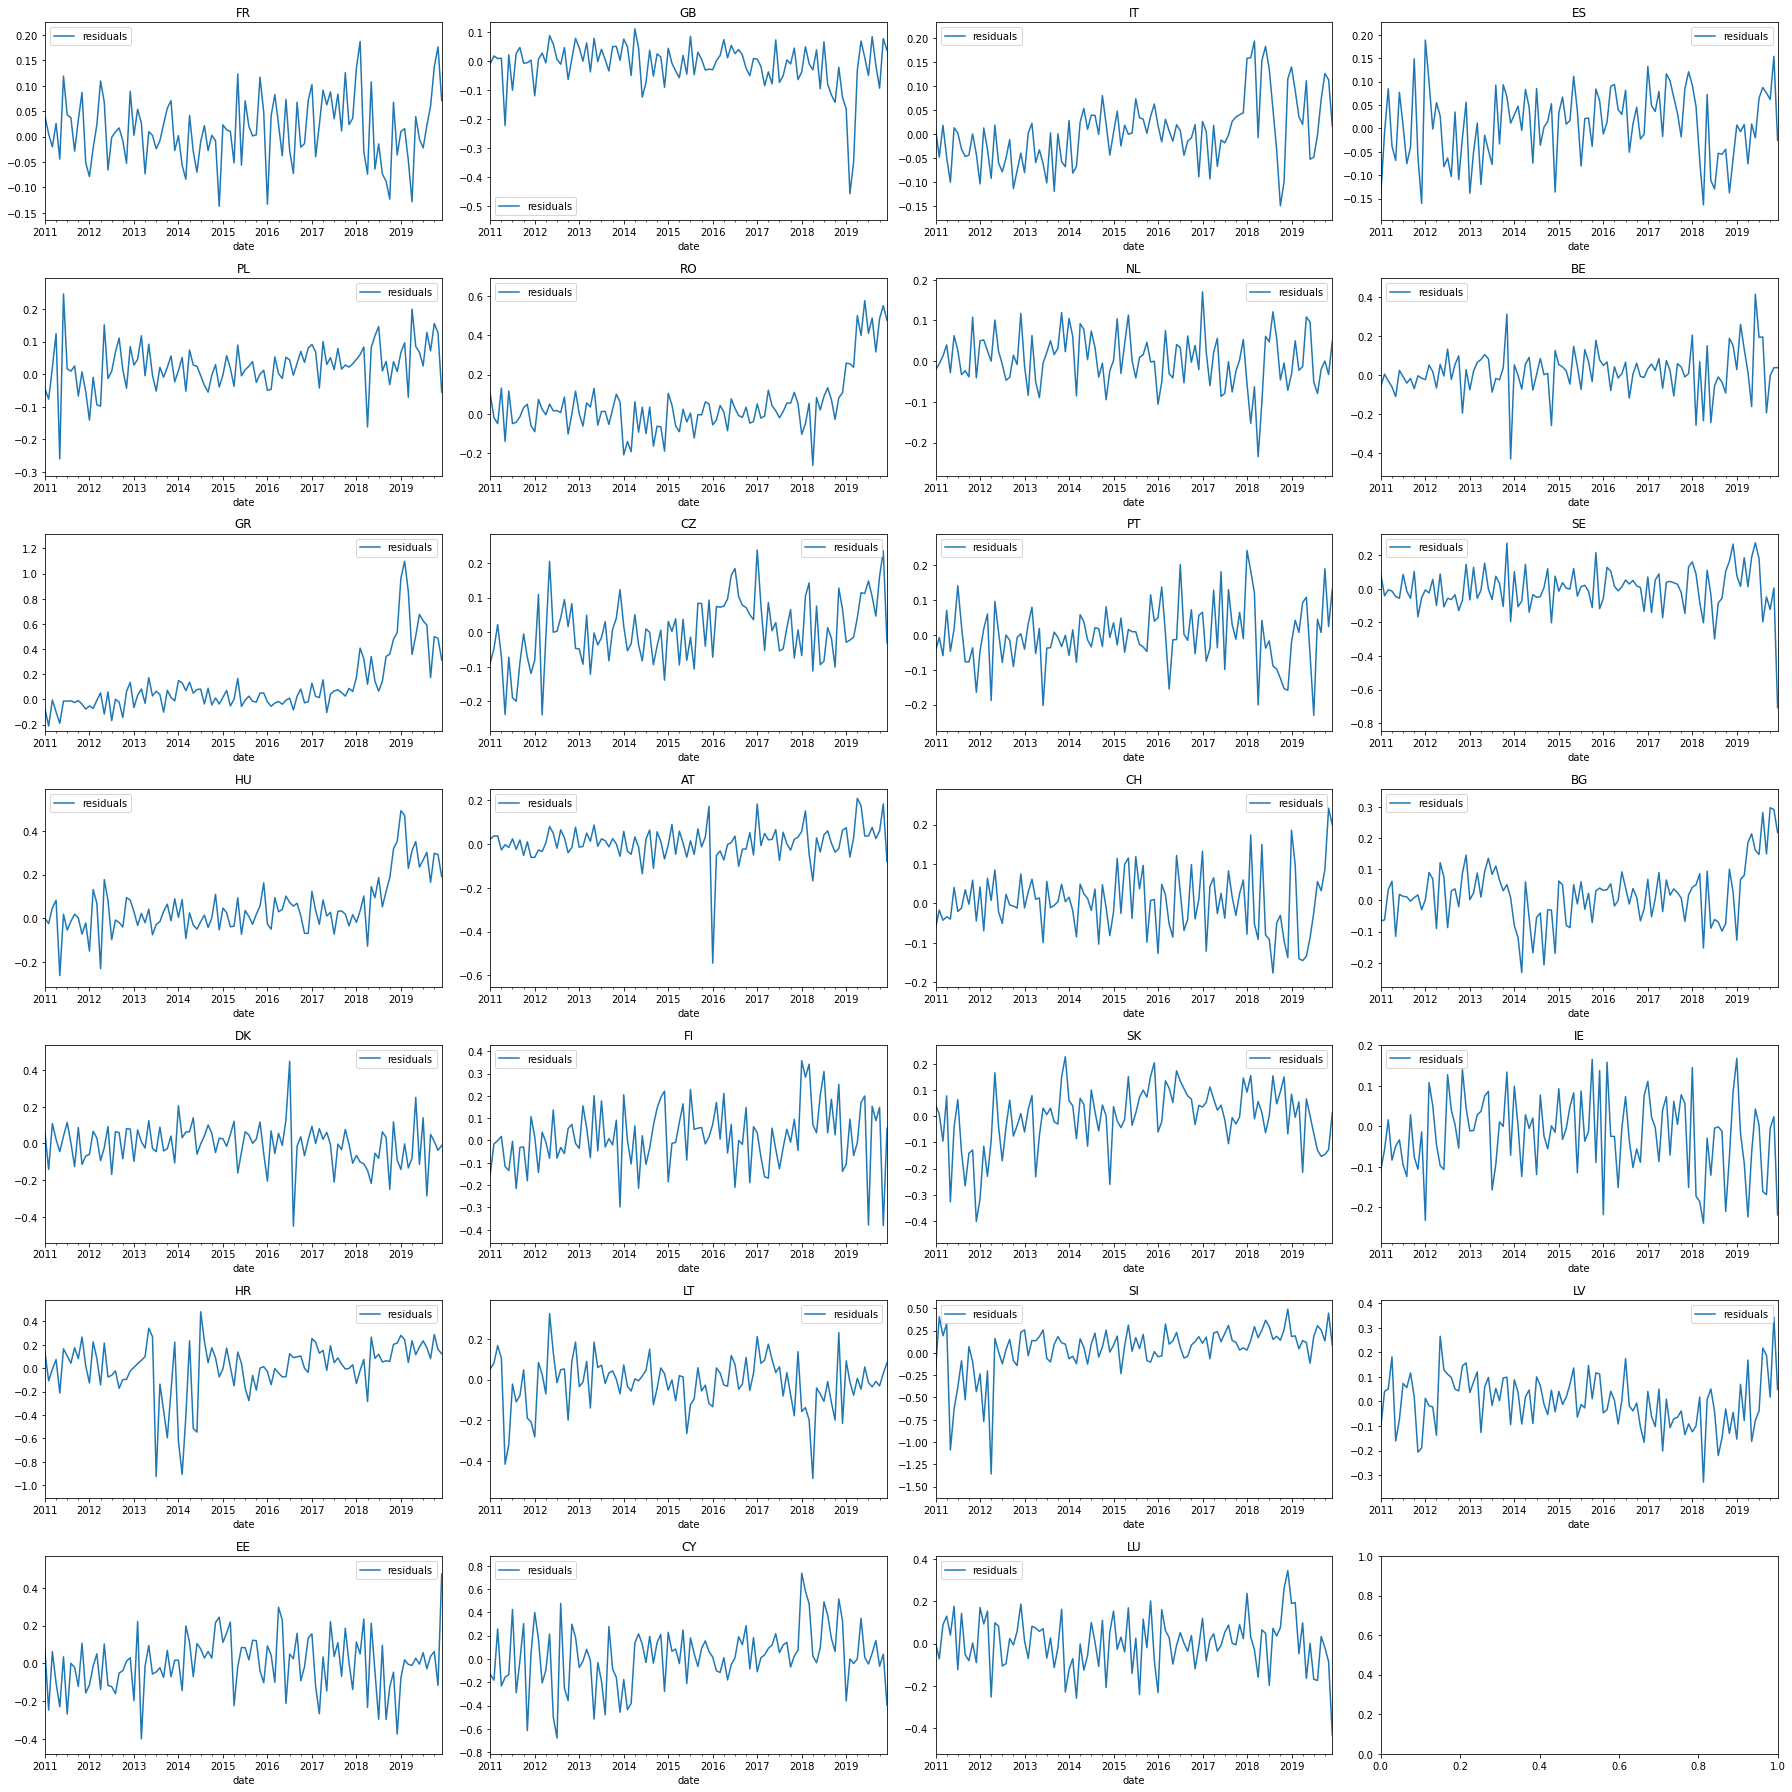

In [14]:
features = (
    dummy_cols
    + dummy_cols_month
    + keyword_ids
    # + ["ar_1"]
    # + ["19_1", "19_2", "19_3", "19_4"]
    + [k + "_3" for k in keyword_ids]
    + [k + "_6" for k in keyword_ids]
    + [k + "_9" for k in keyword_ids]
    + [k + "_12" for k in keyword_ids]
)

reg_unfitted = neural_network.MLPRegressor(alpha=1.0)
# reg_unfitted = linear_model.LinearRegression()
pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), reg_unfitted)
params = {
    "mlpregressor__alpha": [0.1, 0.3, 1.0, 3.0, 10.0],
}
tuner = model_selection.GridSearchCV(
    pipe, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

# lasso_coefs = reg.coef_
# print("ElasticNet Coefficients:")
# print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])

